<a href="https://colab.research.google.com/github/juacastanori/TAM/blob/main/Parcial_1/TAM_Parcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Parcial 1 - Juan Jerónimo Castaño

Utilizando un esquema de validacion cruzada de 5 folds, compare el rendimiento de los siguientes regresores de sklearn sobre el conjunto de datos Ames Housing Dataset: https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset:

• LinearRegresor
• Lasso
• ElasticNet
• KernelRidge
• SGDRegressor
• BayesianRidge
• Gaussian Process Regressor
• RandomForestRegressor
• Support Vector Machines Regressor

Utilice GridSearch, RandomSearch y optimización Bayesiana con muestreo tipo Gaussian Processes para encontrar los hiperparametros relevantes de cada modelo. Justifique los hiper-parametros a buscar, la rejilla o cotas de valores escogida para cada algoritmo segun los modelos estudiados y el score a minimizar. Finalmente, presente los rendimientos promedios en los datos de
evaluacion con su respectiva desviacion estandar para las siguientes medidas de desempeño: MAE, MSE, R2 (consultar) y MAPE
(consultar).

##Desarrollo



El Ames Housing Dataset es un conjunto de datos que contiene información detallada sobre las características de viviendas en Ames, Iowa, y sus respectivos precios de venta. Es ampliamente utilizado para prácticas de regresión debido a su riqueza en variables y complejidad moderada.

##Características del conjunto de datos
• Número de observaciones: 2,930 propiedades.

• Número de variables: 80 características que describen cada propiedad.

Tipos de variables:

• Numéricas continuas: como LotArea, GrLivArea, SalePrice.

• Numéricas discretas: como BedroomAbvGr, TotRmsAbvGrd.

• Categóricas nominales: como Neighborhood, HouseStyle.

• Categóricas ordinales: como ExterQual, BsmtQual.

• Variable de salida: El target del dataset es la variable "SalePrice" que representa el precio de las casas

##Consideraciones para el preprocesamiento

• Valores faltantes: Algunas variables tienen valores faltantes que deben ser tratados adecuadamente. Por ejemplo, PoolQC tiene muchos valores nulos que indican ausencia de piscina.

• Transformaciones: La variable objetivo SalePrice presenta una distribución sesgada a la derecha. Aplicar una transformación logarítmica puede ayudar a normalizar la distribución.

• Codificación de variables categóricas: Las variables categóricas deben ser transformadas en variables numéricas mediante técnicas como One-Hot Encoding o codificación ordinal, dependiendo del modelo a utilizar.

• Escalado de características: Es recomendable escalar las variables numéricas para modelos sensibles a la escala, como la regresión lineal o SVM.



Se instala Optuna para hacer la búsqueda de Hiperparametros

In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 12.9 MB/s eta 0:00:00


Instalo las librerias necesarias

In [ ]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from itertools import product
from scipy.stats import uniform
from pandas.plotting import scatter_matrix
from scipy.interpolate import griddata


Descargo el dataset:

In [ ]:
FILEID="1nsYKXBr0JtdWQWzSbtlAk6Qjj-YU_aSl"
FILENAME="ames.csv"

!wget --load-cookies /tmp/cookies.txt \
    "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt \
    --keep-session-cookies --no-check-certificate \
    'https://docs.google.com/uc?export=download&id='$FILEID -O- \
    | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILEID" \
    -O $FILENAME && rm -rf /tmp/cookies.txt

--2025-05-22 21:27:38--  https://docs.google.com/uc?export=download&confirm=&id=1nsYKXBr0JtdWQWzSbtlAk6Qjj-YU_aSl
Resolving docs.google.com (docs.google.com)... 142.250.31.101, 142.250.31.139, 142.250.31.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.31.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1nsYKXBr0JtdWQWzSbtlAk6Qjj-YU_aSl&export=download [following]
--2025-05-22 21:27:38--  https://drive.usercontent.google.com/download?id=1nsYKXBr0JtdWQWzSbtlAk6Qjj-YU_aSl&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 192.178.218.132, 2607:f8b0:4004:c25::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|192.178.218.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 963738 (941K) [application/octet-stream]
Saving to: ‘ames.csv’

ames.csv            100%[===================>] 941.15K  --.-KB/s 

Leer csv

In [ ]:
df = pd.read_csv("ames.csv")
df.head()

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0        0       5    2010       WD           Normal     215000  
1        0       6    2010       WD           Normal     105000  
2    12500       6    2010       WD           Normal     172000  
3        0       4    2010       WD           Normal     244000  
4        0       3    2010       WD           Normal     189900  

[5 rows x 82 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

Se presentan atributos tipo int, float y texto, algunos de ellos con datos perdidos. Para este caso, se eliminarán columnas:

Order:	Solo un índice de entrada

PID:	ID único de la propiedad

Estas columnas no aportan información útil para predecir SalePrice

Pool QC	~99.6%  nulos

Misc Feature	~96.4% nulos

Alley	~93%	nulos

Fence	~80.5%	nulos

Fireplace Qu	~49%  nulos

Estas columnas se van a eliminar

In [ ]:
df.drop(columns=["Order", "PID", "Pool QC", "Misc Feature", "Alley", "Fence", "Fireplace Qu"], inplace=True)

Parto para 70% de los datos para entrenar y 30% para predecir

In [ ]:
# Separar variable objetivo
col_sal = "SalePrice"

Xtrain, Xtest = train_test_split(df, test_size=0.3, random_state=42)

ytrain = Xtrain[col_sal].copy()
ytest = Xtest[col_sal].copy()

Xtrain.drop(columns=[col_sal], inplace=True)
Xtest.drop(columns=[col_sal], inplace=True)

Hago el preprocesado para completar datos y codificar datos tipo texto, en este caso con OrdinalEncoder

In [ ]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
print(f"Columnas categóricas: {cat_cols}")

Columnas categóricas: ['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Sale Type', 'Sale Condition']


In [ ]:
cat_items = []
for col in cat_cols:
    cat_items.append(list(df[col].value_counts().index))

cat_usr = dict(zip(cat_cols, cat_items))

In [ ]:
ordinal_encoder = OrdinalEncoder(categories=[cat_usr[col] for col in cat_cols])

In [ ]:
cat_cols = df.select_dtypes(include='object').columns
cat_usr = {col: list(df[col].dropna().unique()) for col in cat_cols}

Se crea clase propia (custom) para ejecutar el preproceso que sea compatible con scikitlearn

In [ ]:
class AmesPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, cat_usr):
        self.cat_usr = cat_usr

    def fit(self, X, *_):
        Xi = X.copy()

        # Separar columnas categóricas y numéricas
        self.cat_cols = list(self.cat_usr.keys())
        self.num_cols = [col for col in Xi.columns if col not in self.cat_cols]

        # Imputadores
        self.imputer_cat = SimpleImputer(strategy="most_frequent")
        self.imputer_num = SimpleImputer(strategy="median")

        Xi[self.cat_cols] = self.imputer_cat.fit_transform(Xi[self.cat_cols])
        Xi[self.num_cols] = self.imputer_num.fit_transform(Xi[self.num_cols])

        # Codificador
        self.encoder = OrdinalEncoder(categories=[self.cat_usr[col] for col in self.cat_cols])
        Xi[self.cat_cols] = self.encoder.fit_transform(Xi[self.cat_cols])

        return self

    def transform(self, X, *_):
        Xi = X.copy()

        Xi[self.cat_cols] = self.imputer_cat.transform(Xi[self.cat_cols])
        Xi[self.num_cols] = self.imputer_num.transform(Xi[self.num_cols])
        Xi[self.cat_cols] = self.encoder.transform(Xi[self.cat_cols])

        return Xi

In [ ]:
preprocessor = AmesPreprocessor(cat_usr=cat_usr)
Xtrain_pre = preprocessor.fit_transform(Xtrain)
Xtest_pre = preprocessor.transform(Xtest)

Se puede graficar la matriz de correlación añadiendo la columna de salida para ver que variables pueden tener más relación con la salida

In [ ]:
Xtrain_pre2 = Xtrain_pre.copy()
Xtrain_pre2['output'] = ytrain
corr_matrix2 = Xtrain_pre2.corr()#matriz de correlación
corr_matrix2.style.background_gradient(cmap='coolwarm')

In [ ]:
abs(corr_matrix2["output"]).sort_values(ascending=False)

output             1.000000
Overall Qual       0.792383
Gr Liv Area        0.699668
Garage Cars        0.640721
Garage Area        0.625963
                     ...   
Bsmt Exposure      0.013467
Condition 2        0.013314
Low Qual Fin SF    0.010829
Sale Type          0.006609
BsmtFin Type 2     0.004202
Name: output, Length: 75, dtype: float64

Las variables que más tienen relación con la variable de salida son:

- Overall Qual

- Gr Liv Area

- Garage Cars

Se pueden pintar diagrama de dispersión y de bigotes para estas variables

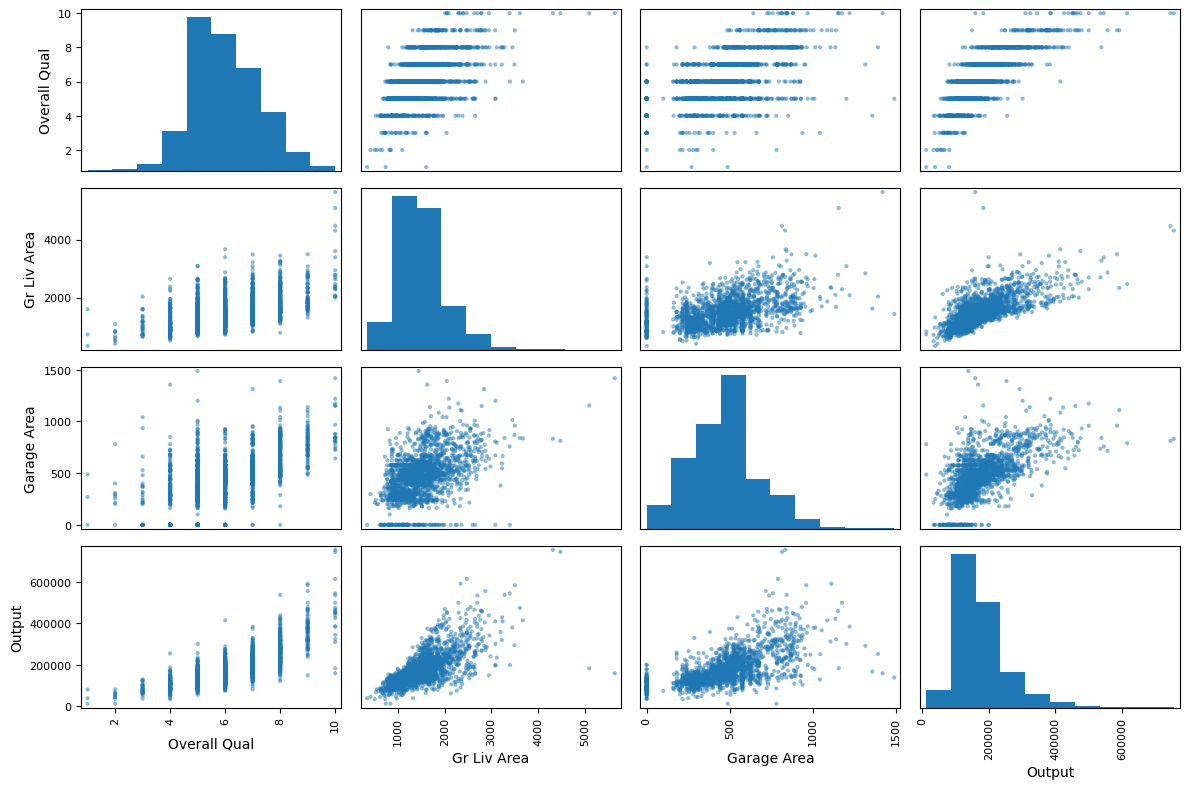

In [ ]:
Xm =pd.DataFrame(Xtrain_pre[['Overall Qual','Gr Liv Area','Garage Area']],columns=['Overall Qual','Gr Liv Area','Garage Area'])#definir pandas con atributos seleccionados
Xm['Output'] = ytrain #agregar salida


Xm.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

Se normaliza con la función MinMaxScaler() para mejor visualización

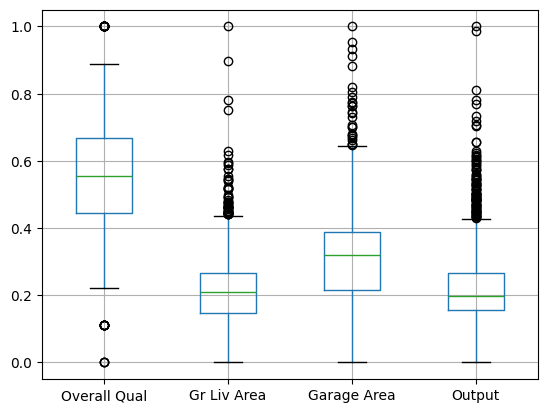

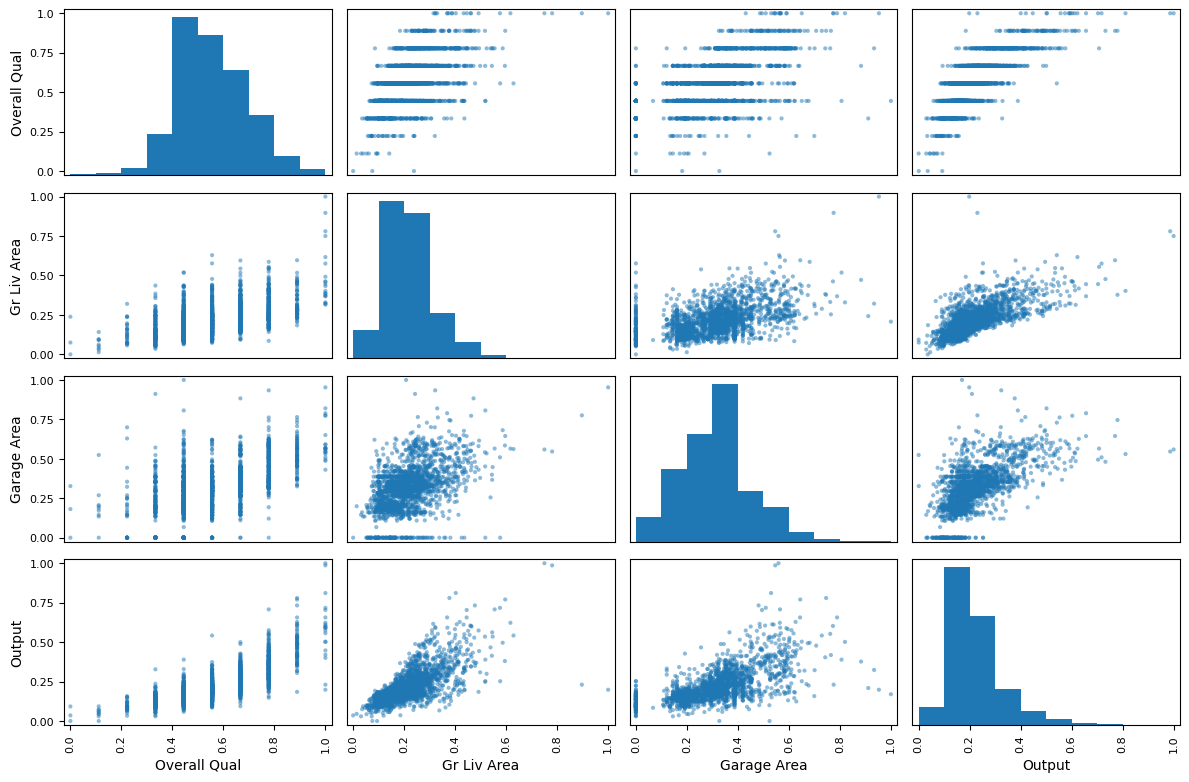

In [ ]:
#scaler = StandardScaler()
scaler = MinMaxScaler()

Xm_pre_sca = pd.DataFrame(scaler.fit_transform(Xm),columns=Xm.columns)
Xm_pre_sca.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm_pre_sca, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

Se define pipeline para entrenar un modelo de regresión

Se va a utilizar un preproceso de normalización tipo MinMaxScaler para evitar problemas de escala a la hora de identificar los patrones de interés.

Se va a hacer validación cruzada de 5 folds


Defino las métricas de evaluación:

Las metricas se definen como:

- MAE Mean Absolute Error

Promedio de las diferencias absolutas entre los valores reales y predichos. Es fácil de interpretar porque tiene las mismas unidades que la variable objetivo.

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$



- MSE Mean Squared Error

Promedio de los errores al cuadrado. Penaliza mucho los errores grandes (outliers). Se usa comúnmente para funciones de pérdida.

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
$$

- R2 Coeficiente de Determinación

Mide qué porcentaje de la varianza de los datos se explica por el modelo. Un valor de 1 indica un ajuste perfecto.

$$
R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$


- MAPE Mean Absolute Percentage Error

Es el error absoluto expresado como porcentaje del valor real. Útil para interpretar el error relativo.

$$
\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$




En problemas de regresión donde la variable objetivo (SalePrice, en este caso) tiene una distribución altamente sesgada o con valores extremos (outliers), se aplica la transformación a logaritmo

Esto tiene dos objetivos:

- Reducir la varianza de la salida (normalizar su distribución)

- Evitar que los errores grandes dominen la función de pérdida

Luego, al predecir, se revierte para obtener la salida predecida a sus valores reales

LinearRegression

$$
\min_{w} \; \frac{1}{2n} \| Xw - y \|_2^2
$$


Al no tener hiperparametros no se aplica búsqueda de hiperparametros

In [ ]:
# Transformar variable objetivo a escala logarítmica
ytrain_log = np.log1p(ytrain)
ytest_log = np.log1p(ytest)

# Pipeline para LinearRegression
pipeline_lr_log = Pipeline([
    ('preprocessing', preprocessor),
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para guardar métricas por fold
maes, mses, r2s, mapes = [], [], [], []

# Validación cruzada manual para poder aplicar expm1 en cada fold
for train_idx, val_idx in kf.split(Xtrain):
    X_tr, X_val = Xtrain.iloc[train_idx], Xtrain.iloc[val_idx]
    y_tr, y_val = ytrain_log.iloc[train_idx], ytrain.iloc[val_idx]  # y_val en escala real

    # Entrenar modelo con y_log
    pipeline_lr_log.fit(X_tr, y_tr)

    # Predecir y volver a escala real
    y_pred_val_log = pipeline_lr_log.predict(X_val)
    y_pred_val = np.expm1(y_pred_val_log)

    # Calcular métricas
    maes.append(mean_absolute_error(y_val, y_pred_val))
    mses.append(mean_squared_error(y_val, y_pred_val))
    r2s.append(r2_score(y_val, y_pred_val))
    mapes.append(mean_absolute_percentage_error(y_val, y_pred_val))

# Mostrar resultados promedio ± desviación estándar
print("📈 Validación cruzada (5 folds) - LinearRegression con log1p(y):")
print(f"MAE:  {np.mean(maes):.0f} ± {np.std(maes):.0f}")
print(f"MSE:  {np.mean(mses):.0f} ± {np.std(mses):.0f}")
print(f"R2:   {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
print(f"MAPE: {np.mean(mapes):.4f} ± {np.std(mapes):.4f}")

# Ajustar el modelo completo con y_log
pipeline_lr_log.fit(Xtrain, ytrain_log)

# Predecir con Xtest y volver a escala real
y_pred_test_log = pipeline_lr_log.predict(Xtest)
y_pred_test = np.expm1(y_pred_test_log)

print("\n📊 Evaluación en conjunto de prueba (Xtest) - LinearRegression con log1p(y):")
print(f"MAE:  {mean_absolute_error(ytest, y_pred_test):.4f}")
print(f"MSE:  {mean_squared_error(ytest, y_pred_test):.4f}")
print(f"R2:   {r2_score(ytest, y_pred_test):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(ytest, y_pred_test):.4f}")


📈 Validación cruzada (5 folds) - LinearRegression con log1p(y):
MAE:  18745 ± 2031
MSE:  4841566899 ± 6165177369
R2:   0.1316 ± 1.1617
MAPE: 0.1106 ± 0.0172

📊 Evaluación en conjunto de prueba (Xtest) - LinearRegression con log1p(y):
MAE:  17764.4901
MSE:  1145715390.1906
R2:   0.8370
MAPE: 0.0969


En la validación cruzada (CV), se dividen los datos de entrenamiento en varias particiones (folds), y por eso se pueden calcular varias métricas, una por cada fold, y luego obtener:

Promedio ± Desviación estándar

En Xtest se hace solo una evaluación, una única prediccion con el modelo entrenado completo. Solo hay una evaluación final sobre el conjunto Xtest.

Esa evaluación se usa para estimar el rendimiento del modelo ya entrenado sobre datos completamente nuevos (como si fuera producción).

Para los siguientes modelos se realizará de esta forma



Lasso

$$
\min_{w} \; \frac{1}{2n} \| Xw - y \|_2^2 + \alpha \| w \|_1
$$


In [ ]:
# Transformar y a escala logarítmica
ytrain_log = np.log1p(ytrain)
ytest_log = np.log1p(ytest)

# === BÚSQUEDA DE HIPERPARÁMETROS ===

param_grid = {
    'model__alpha': np.logspace(-4, 1, 20)
}

def build_lasso_pipeline(alpha):
    return Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', MinMaxScaler()),
        ('model', Lasso(alpha=alpha, max_iter=5000))
    ])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('scaler', MinMaxScaler()),
    ('model', Lasso(max_iter=5000))
])

# --- GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)
grid.fit(Xtrain, ytrain_log)
best_alpha_grid = grid.best_params_['model__alpha']
print("🔧 Mejor alpha (GridSearch):", best_alpha_grid)

# --- RandomSearchCV
random = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=42
)
random.fit(Xtrain, ytrain_log)
best_alpha_random = random.best_params_['model__alpha']
print("🔧 Mejor alpha (RandomSearch):", best_alpha_random)

# --- Optimización Bayesiana con Optuna
import optuna

def objective_lasso(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 10)
    model = Lasso(alpha=alpha, max_iter=5000)
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])
    scores = cross_validate(
        pipeline, Xtrain, ytrain_log,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1
    )
    return -np.mean(scores['test_score'])

study = optuna.create_study(direction='minimize')
study.optimize(objective_lasso, n_trials=30)
best_alpha_optuna = study.best_params['alpha']
print("🔧 Mejor alpha (Optuna):", best_alpha_optuna)


🔧 Mejor alpha (GridSearch): 0.00018329807108324357


[I 2025-05-22 22:18:04,767] A new study created in memory with name: no-name-250e7447-9efc-4214-ac67-eb463e3d30ff


🔧 Mejor alpha (RandomSearch): 0.00018329807108324357


<ipython-input-20-35b478303c97>:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 10)
[I 2025-05-22 22:18:05,450] Trial 0 finished with value: 0.30759392817670833 and parameters: {'alpha': 1.5144160859076459}. Best is trial 0 with value: 0.30759392817670833.
[I 2025-05-22 22:18:06,123] Trial 1 finished with value: 0.1849957405358617 and parameters: {'alpha': 0.021038196440032013}. Best is trial 1 with value: 0.1849957405358617.
[I 2025-05-22 22:18:07,160] Trial 2 finished with value: 0.09608691827777771 and parameters: {'alpha': 0.00011218201596346944}. Best is trial 2 with value: 0.09608691827777771.
[I 2025-05-22 22:18:08,288] Trial 3 finished with value: 0.30759392817670833 and parameters: {'alpha': 0.41724420651726074}. Best is trial 2 with value: 0.09608691827777771.
[I 2025-

🔧 Mejor alpha (Optuna): 0.00015292670612741325


In [ ]:
def evaluar_modelo_cv_test(nombre, alpha, Xtrain, ytrain_log, ytest, ytest_log):
    pipeline = build_lasso_pipeline(alpha)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    maes, mses, r2s, mapes = [], [], [], []

    for train_idx, val_idx in kf.split(Xtrain):
        X_tr, X_val = Xtrain.iloc[train_idx], Xtrain.iloc[val_idx]
        y_tr, y_val = ytrain_log.iloc[train_idx], ytrain.iloc[val_idx]
        pipeline.fit(X_tr, y_tr)
        y_pred_val = np.expm1(pipeline.predict(X_val))
        maes.append(mean_absolute_error(y_val, y_pred_val))
        mses.append(mean_squared_error(y_val, y_pred_val))
        r2s.append(r2_score(y_val, y_pred_val))
        mapes.append(mean_absolute_percentage_error(y_val, y_pred_val))

    print(f"\n📈 Validación cruzada (5 folds) - {nombre}")
    print(f"MAE:  {np.mean(maes):.0f} ± {np.std(maes):.0f}")
    print(f"MSE:  {np.mean(mses):.0f} ± {np.std(mses):.0f}")
    print(f"R2:   {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
    print(f"MAPE: {np.mean(mapes):.4f} ± {np.std(mapes):.4f}")

    pipeline.fit(Xtrain, ytrain_log)
    y_pred_test = np.expm1(pipeline.predict(Xtest))

    print(f"\n📊 Evaluación en conjunto de prueba (Xtest) - {nombre}")
    print(f"MAE:  {mean_absolute_error(ytest, y_pred_test):.4f}")
    print(f"MSE:  {mean_squared_error(ytest, y_pred_test):.4f}")
    print(f"R2:   {r2_score(ytest, y_pred_test):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(ytest, y_pred_test):.4f}")

# Ejecutar evaluaciones
evaluar_modelo_cv_test("Lasso - GridSearch", best_alpha_grid, Xtrain, ytrain_log, ytest, ytest_log)
evaluar_modelo_cv_test("Lasso - RandomSearch", best_alpha_random, Xtrain, ytrain_log, ytest, ytest_log)
evaluar_modelo_cv_test("Lasso - Optuna", best_alpha_optuna, Xtrain, ytrain_log, ytest, ytest_log)



📈 Validación cruzada (5 folds) - Lasso - GridSearch
MAE:  18319 ± 1598
MSE:  3459642508 ± 4359574883
R2:   0.3794 ± 0.8257
MAPE: 0.1082 ± 0.0148

📊 Evaluación en conjunto de prueba (Xtest) - Lasso - GridSearch
MAE:  17830.9760
MSE:  1095695379.3329
R2:   0.8441
MAPE: 0.0967

📈 Validación cruzada (5 folds) - Lasso - RandomSearch
MAE:  18319 ± 1598
MSE:  3459642508 ± 4359574883
R2:   0.3794 ± 0.8257
MAPE: 0.1082 ± 0.0148

📊 Evaluación en conjunto de prueba (Xtest) - Lasso - RandomSearch
MAE:  17830.9760
MSE:  1095695379.3329
R2:   0.8441
MAPE: 0.0967

📈 Validación cruzada (5 folds) - Lasso - Optuna
MAE:  18340 ± 1654
MSE:  3567120894 ± 4511812523
R2:   0.3600 ± 0.8542
MAPE: 0.1083 ± 0.0151

📊 Evaluación en conjunto de prueba (Xtest) - Lasso - Optuna
MAE:  17786.2768
MSE:  1101826495.4992
R2:   0.8433
MAPE: 0.0966


Gráfica de Búsquedas:

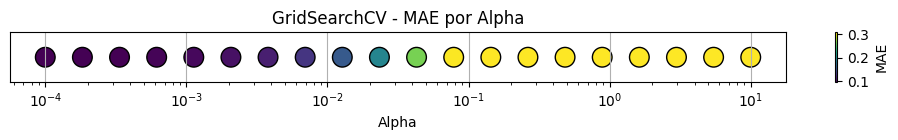

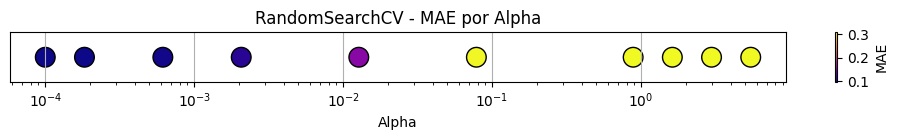

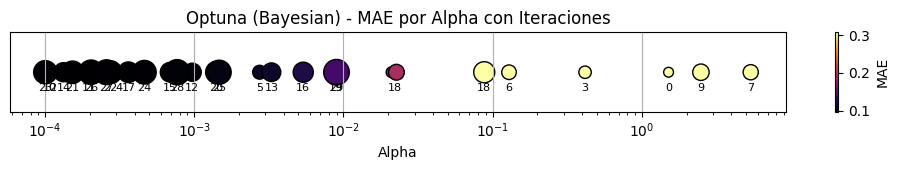

In [ ]:
#Grid
alphas = grid.param_grid['model__alpha']
scores = -grid.cv_results_['mean_test_score']  # convertir a positivo MAE

plt.figure(figsize=(10, 1.5))
sc = plt.scatter(alphas, [0]*len(alphas), c=scores, cmap='viridis', s=200, edgecolors='k')
plt.xscale('log')
plt.xlabel('Alpha')
plt.yticks([])
plt.title('GridSearchCV - MAE por Alpha')
plt.colorbar(sc, label='MAE')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


#Random
alphas_rand = random.cv_results_['param_model__alpha'].data
scores_rand = -random.cv_results_['mean_test_score']

plt.figure(figsize=(10, 1.5))
sc = plt.scatter(alphas_rand, [0]*len(alphas_rand), c=scores_rand, cmap='plasma', s=200, edgecolors='k')
plt.xscale('log')
plt.xlabel('Alpha')
plt.yticks([])
plt.title('RandomSearchCV - MAE por Alpha')
plt.colorbar(sc, label='MAE')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

#Bayesian
optuna_alphas = [t.params['alpha'] for t in study.trials if t.value is not None]
optuna_scores = [t.value for t in study.trials if t.value is not None]
optuna_iter = list(range(len(optuna_alphas)))  # número de iteración

plt.figure(figsize=(10, 1.8))

# Scatter con tamaño creciente según iteración
sc = plt.scatter(optuna_alphas, [0]*len(optuna_alphas),
                 c=optuna_scores, cmap='inferno',
                 s=[50 + i*10 for i in optuna_iter],
                 edgecolors='k')

# Texto horizontal, muy cerca del punto
for i, (a, v) in enumerate(zip(optuna_alphas, optuna_scores)):
    plt.text(a, -0.015, str(i), fontsize=8, ha='center', va='top', rotation=0)

plt.xscale('log')
plt.xlabel('Alpha')
plt.yticks([])
plt.title('Optuna (Bayesian) - MAE por Alpha con Iteraciones')
plt.colorbar(sc, label='MAE')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

ElasticNet

$$
\min_{w} \; \frac{1}{2n} \| Xw - y \|_2^2 + \alpha \left( \rho \| w \|_1 + \frac{1 - \rho}{2} \| w \|_2^2 \right)
$$


In [ ]:
# Aplicar transformación logarítmica
ytrain_log = np.log1p(ytrain)
ytest_log = np.log1p(ytest)


In [ ]:
param_grid = {
    'model__alpha': np.logspace(-4, 1, 10),
    'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}


In [ ]:
def build_elasticnet_pipeline(alpha, l1_ratio):
    return Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', MinMaxScaler()),
        ('model', ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=5000))
    ])


In [ ]:
pipeline_base = Pipeline([
    ('preprocessing', preprocessor),
    ('scaler', MinMaxScaler()),
    ('model', ElasticNet(max_iter=5000))
])

grid = GridSearchCV(
    pipeline_base,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)
grid.fit(Xtrain, ytrain_log)
best_alpha_grid = grid.best_params_['model__alpha']
best_l1_grid = grid.best_params_['model__l1_ratio']
print("🔧 GridSearch - mejores params:", grid.best_params_)


🔧 GridSearch - mejores params: {'model__alpha': np.float64(0.00035938136638046257), 'model__l1_ratio': 0.5}


In [ ]:
random = RandomizedSearchCV(
    pipeline_base,
    param_distributions=param_grid,
    n_iter=15,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=42
)
random.fit(Xtrain, ytrain_log)
best_alpha_random = random.best_params_['model__alpha']
best_l1_random = random.best_params_['model__l1_ratio']
print("🔧 RandomSearch - mejores params:", random.best_params_)


🔧 RandomSearch - mejores params: {'model__l1_ratio': 0.7, 'model__alpha': np.float64(0.00035938136638046257)}


In [ ]:
def objective_elastic(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 10)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.1, 0.9)
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=5000)

    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])

    scores = cross_validate(
        pipeline, Xtrain, ytrain_log,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1
    )

    return -np.mean(scores['test_score'])

study = optuna.create_study(direction='minimize')
study.optimize(objective_elastic, n_trials=30)
best_alpha_optuna = study.best_params['alpha']
best_l1_optuna = study.best_params['l1_ratio']
print("🔧 Optuna - mejores params:", study.best_params)


[I 2025-05-22 23:26:26,243] A new study created in memory with name: no-name-52b61ee2-13c6-4079-9e9a-76f464141c27
<ipython-input-42-9314c0fb0fb7>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 10)
<ipython-input-42-9314c0fb0fb7>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.1, 0.9)
[I 2025-05-22 23:26:27,001] Trial 0 finished with value: 0.09634625560211697 and parameters: {'alpha': 0.0005234315487438433, 'l1_ratio': 0.6099249486168753}. Best is trial 0 with value: 0.09634625560211697.
[I 2025-05-22 23:26:27,702] Trial 1 finished with value: 0.28315740522815663 and parameters: {'alpha': 0.

🔧 Optuna - mejores params: {'alpha': 0.0002636738692049828, 'l1_ratio': 0.6894112101581346}


In [ ]:
def evaluar_modelo_cv_test(nombre, alpha, l1_ratio):
    pipeline = build_elasticnet_pipeline(alpha, l1_ratio)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    maes, mses, r2s, mapes = [], [], [], []

    for train_idx, val_idx in kf.split(Xtrain):
        X_tr, X_val = Xtrain.iloc[train_idx], Xtrain.iloc[val_idx]
        y_tr, y_val = ytrain_log.iloc[train_idx], ytrain.iloc[val_idx]

        pipeline.fit(X_tr, y_tr)
        y_pred_val = np.expm1(pipeline.predict(X_val))

        maes.append(mean_absolute_error(y_val, y_pred_val))
        mses.append(mean_squared_error(y_val, y_pred_val))
        r2s.append(r2_score(y_val, y_pred_val))
        mapes.append(mean_absolute_percentage_error(y_val, y_pred_val))

    print(f"\n📈 Validación cruzada (5 folds) - {nombre}")
    print(f"MAE:  {np.mean(maes):.0f} ± {np.std(maes):.0f}")
    print(f"MSE:  {np.mean(mses):.0f} ± {np.std(mses):.0f}")
    print(f"R2:   {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
    print(f"MAPE: {np.mean(mapes):.4f} ± {np.std(mapes):.4f}")

    # Evaluación en conjunto de prueba
    pipeline.fit(Xtrain, ytrain_log)
    y_pred_test_log = pipeline.predict(Xtest)
    y_pred_test = np.expm1(y_pred_test_log)

    print(f"\n📊 Evaluación en test - {nombre}")
    print(f"MAE:  {mean_absolute_error(ytest, y_pred_test):.4f}")
    print(f"MSE:  {mean_squared_error(ytest, y_pred_test):.4f}")
    print(f"R2:   {r2_score(ytest, y_pred_test):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(ytest, y_pred_test):.4f}")



In [ ]:
evaluar_modelo_cv_test("ElasticNet - GridSearch", best_alpha_grid, best_l1_grid)
evaluar_modelo_cv_test("ElasticNet - RandomSearch", best_alpha_random, best_l1_random)
evaluar_modelo_cv_test("ElasticNet - Optuna", best_alpha_optuna, best_l1_optuna)



📈 Validación cruzada (5 folds) - ElasticNet - GridSearch
MAE:  18261 ± 1450
MSE:  3287845471 ± 4076217420
R2:   0.4110 ± 0.7724
MAPE: 0.1078 ± 0.0142

📊 Evaluación en test - ElasticNet - GridSearch
MAE:  17890.8718
MSE:  1075121889.2408
R2:   0.8471
MAPE: 0.0969

📈 Validación cruzada (5 folds) - ElasticNet - RandomSearch
MAE:  18256 ± 1389
MSE:  3161036489 ± 3910171688
R2:   0.4337 ± 0.7414
MAPE: 0.1078 ± 0.0140

📊 Evaluación en test - ElasticNet - RandomSearch
MAE:  17979.5780
MSE:  1070989065.7859
R2:   0.8476
MAPE: 0.0972

📈 Validación cruzada (5 folds) - ElasticNet - Optuna
MAE:  18291 ± 1534
MSE:  3390324252 ± 4247093869
R2:   0.3921 ± 0.8045
MAPE: 0.1080 ± 0.0146

📊 Evaluación en test - ElasticNet - Optuna
MAE:  17863.5551
MSE:  1084122388.1891
R2:   0.8458
MAPE: 0.0968


Gráfica de Búsquedas:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer resultados
results_grid = grid.cv_results_
alphas = param_grid['model__alpha']
l1_ratios = param_grid['model__l1_ratio']

# Extraer valores individuales de cada combinación
alpha_vals = [p['model__alpha'] for p in results_grid['params']]
l1_vals = [p['model__l1_ratio'] for p in results_grid['params']]
maes = [-m for m in results_grid['mean_test_score']]  # pasar a positivo

# Graficar como scatter
plt.figure(figsize=(8, 5))
sc = plt.scatter(alpha_vals, l1_vals, c=maes, cmap='viridis', s=150, edgecolors='k')
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("l1_ratio")
plt.title("GridSearchCV - MAE por (alpha, l1_ratio)")
plt.colorbar(sc, label='MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


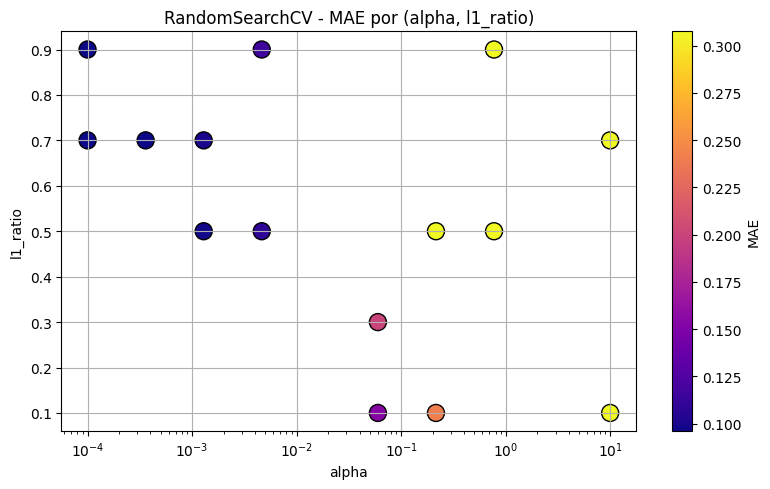

In [ ]:
results_random = random.cv_results_
random_alphas = results_random['param_model__alpha'].data
random_l1s = results_random['param_model__l1_ratio'].data
random_maes = -results_random['mean_test_score']

plt.figure(figsize=(8, 5))
sc = plt.scatter(random_alphas, random_l1s, c=random_maes, cmap='plasma', s=150, edgecolors='k')
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("l1_ratio")
plt.title("RandomSearchCV - MAE por (alpha, l1_ratio)")
plt.colorbar(sc, label='MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


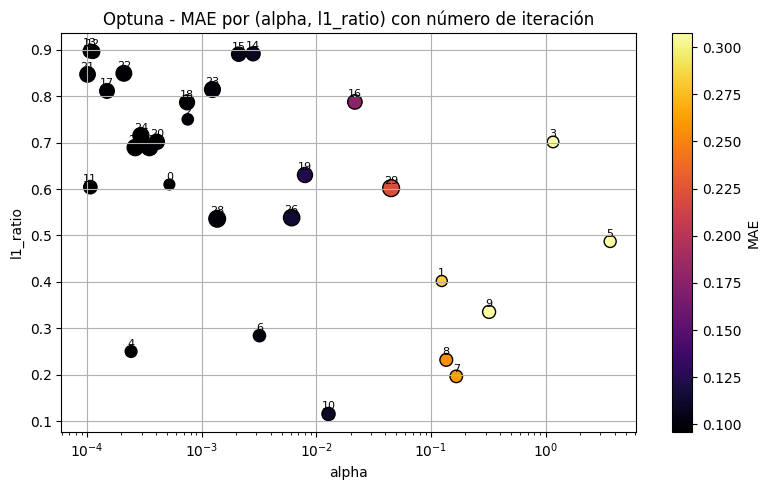

In [ ]:
optuna_alphas = [t.params['alpha'] for t in study.trials if t.value is not None]
optuna_l1s = [t.params['l1_ratio'] for t in study.trials if t.value is not None]
optuna_maes = [t.value for t in study.trials if t.value is not None]

plt.figure(figsize=(8, 5))
sc = plt.scatter(optuna_alphas, optuna_l1s, c=optuna_maes, cmap='inferno',
                 s=[60 + i*3 for i in range(len(optuna_alphas))], edgecolors='k')

for i, (a, l) in enumerate(zip(optuna_alphas, optuna_l1s)):
    plt.text(a, l + 0.01, str(i), fontsize=8, ha='center', rotation=0)

plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("l1_ratio")
plt.title("Optuna - MAE por (alpha, l1_ratio) con número de iteración")
plt.colorbar(sc, label='MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


KernelRidge

$$
\min_{\alpha} \; \| K \alpha - y \|_2^2 + \alpha \| \alpha \|_2^2;  
$$

$$
K = \text{kernel}(X, X)
$$


In [ ]:
ytrain_log = np.log1p(ytrain)
ytest_log = np.log1p(ytest)


In [ ]:
def build_krr_pipeline(params):
    if 'gamma' in params and params['gamma'] is not None:
        model = KernelRidge(
            alpha=params['alpha'],
            kernel=params['kernel'],
            gamma=params['gamma']
        )
    else:
        model = KernelRidge(
            alpha=params['alpha'],
            kernel=params['kernel']
        )

    return Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])


In [ ]:
pipeline_base = Pipeline([
    ('preprocessing', preprocessor),
    ('scaler', MinMaxScaler()),
    ('model', KernelRidge())
])

param_grid_valid = [
    {'model__alpha': [a], 'model__kernel': ['linear']} for a in [0.0001, 0.001, 0.01, 0.1, 1]
] + [
    {'model__alpha': [a], 'model__kernel': ['rbf'], 'model__gamma': [g]}
    for a, g in product([0.0001, 0.001, 0.01, 0.1, 1], [0.001, 0.01, 0.1, 1])
]

grid = GridSearchCV(
    pipeline_base,
    param_grid=param_grid_valid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

grid.fit(Xtrain, ytrain_log)
best_params_grid = {k.replace('model__', ''): v for k, v in grid.best_params_.items()}
print("🔧 GridSearch - mejores params:", best_params_grid)


🔧 GridSearch - mejores params: {'alpha': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
param_dist = {
    'model__alpha': np.logspace(-4, 1, 80),
    'model__kernel': ['rbf'],
    'model__gamma': np.logspace(-4, 1, 80)
}

random = RandomizedSearchCV(
    pipeline_base,
    param_distributions=param_dist,
    n_iter=40,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random.fit(Xtrain, ytrain_log)
best_params_random = {k.replace('model__', ''): v for k, v in random.best_params_.items()}
print("🔧 RandomSearch - mejores params:", best_params_random)


🔧 RandomSearch - mejores params: {'kernel': 'rbf', 'gamma': np.float64(0.012263306841775632), 'alpha': np.float64(0.007920164050192557)}


In [ ]:
def objective_kernelridge(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 10)
    kernel = trial.suggest_categorical('kernel', ['rbf'])

    if kernel == 'rbf':
        gamma = trial.suggest_loguniform('gamma', 1e-4, 10)
    else:
        gamma = None

    model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma)

    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])

    scores = cross_validate(
        pipeline, Xtrain, ytrain_log,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1
    )

    return -np.mean(scores['test_score'])

study = optuna.create_study(direction='minimize')
study.optimize(objective_kernelridge, n_trials=50)

best_params_optuna = study.best_params
print("🔧 Optuna - mejores params:", best_params_optuna)


[I 2025-05-22 23:43:24,135] A new study created in memory with name: no-name-f889ab1c-7d41-4294-b674-1d059078e7cf
<ipython-input-53-f717bd024dac>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 10)
<ipython-input-53-f717bd024dac>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 10)
[I 2025-05-22 23:43:25,657] Trial 0 finished with value: 0.09611664207461694 and parameters: {'alpha': 0.00020066851196104117, 'kernel': 'rbf', 'gamma': 0.00010877684960028965}. Best is trial 0 with value: 0.09611664207461694.
[I 2025-05-22 23:43:27,131] Trial 1 finished with value: 0.264944286926

🔧 Optuna - mejores params: {'alpha': 0.00022064334412644416, 'kernel': 'rbf', 'gamma': 0.0035589264901654824}


In [ ]:
def evaluar_modelo_cv_test(nombre, best_params):
    pipeline = build_krr_pipeline(best_params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    maes, mses, r2s, mapes = [], [], [], []

    for train_idx, val_idx in kf.split(Xtrain):
        X_tr, X_val = Xtrain.iloc[train_idx], Xtrain.iloc[val_idx]
        y_tr, y_val = ytrain_log.iloc[train_idx], ytrain.iloc[val_idx]

        pipeline.fit(X_tr, y_tr)
        y_pred_val = np.expm1(pipeline.predict(X_val))

        maes.append(mean_absolute_error(y_val, y_pred_val))
        mses.append(mean_squared_error(y_val, y_pred_val))
        r2s.append(r2_score(y_val, y_pred_val))
        mapes.append(mean_absolute_percentage_error(y_val, y_pred_val))

    print(f"\n📈 Validación cruzada (5 folds) - {nombre}")
    print(f"MAE:  {np.mean(maes):.0f} ± {np.std(maes):.0f}")
    print(f"MSE:  {np.mean(mses):.0f} ± {np.std(mses):.0f}")
    print(f"R2:   {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
    print(f"MAPE: {np.mean(mapes):.4f} ± {np.std(mapes):.4f}")

    # Evaluación en test
    pipeline.fit(Xtrain, ytrain_log)
    ypred_test_log = pipeline.predict(Xtest)
    ypred_test = np.expm1(ypred_test_log)

    print(f"\n📊 Evaluación en test set - {nombre}")
    print(f"MAE:  {mean_absolute_error(ytest, ypred_test):.4f}")
    print(f"MSE:  {mean_squared_error(ytest, ypred_test):.4f}")
    print(f"R2:   {r2_score(ytest, ypred_test):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(ytest, ypred_test):.4f}")
    return ypred_test


In [ ]:
evaluar_modelo_cv_test("KernelRidge - GridSearch", best_params_grid)
evaluar_modelo_cv_test("KernelRidge - RandomSearch", best_params_random)
ypred_test=evaluar_modelo_cv_test("KernelRidge - Optuna", best_params_optuna)



📈 Validación cruzada (5 folds) - KernelRidge - GridSearch
MAE:  16539 ± 1333
MSE:  2219925808 ± 2152412012
R2:   0.6108 ± 0.4023
MAPE: 0.0982 ± 0.0126

📊 Evaluación en test set - KernelRidge - GridSearch
MAE:  15307.0398
MSE:  839573509.1864
R2:   0.8806
MAPE: 0.0846

📈 Validación cruzada (5 folds) - KernelRidge - RandomSearch
MAE:  16563 ± 490
MSE:  1017657014 ± 451779345
R2:   0.8283 ± 0.0840
MAPE: 0.0975 ± 0.0079

📊 Evaluación en test set - KernelRidge - RandomSearch
MAE:  15931.2531
MSE:  924679810.4213
R2:   0.8685
MAPE: 0.0871

📈 Validación cruzada (5 folds) - KernelRidge - Optuna
MAE:  15670 ± 920
MSE:  1360942729 ± 1008560436
R2:   0.7669 ± 0.1819
MAPE: 0.0943 ± 0.0111

📊 Evaluación en test set - KernelRidge - Optuna
MAE:  14227.0744
MSE:  775345077.3624
R2:   0.8897
MAPE: 0.0803


In [ ]:
ypred_test = pd.DataFrame(ypred_test)
ytest.to_csv("ytestk.csv", index=False, header=False)
ypred_test.to_csv("ypred_testk.csv", index=False, header=False)


Gráfica de búsqueda:

In [ ]:
# Extraer combinaciones rbf (ya que solo estas tienen gamma)
results_grid = grid.cv_results_
grid_alphas = []
grid_gammas = []
grid_maes = []

for score, params in zip(results_grid['mean_test_score'], results_grid['params']):
    if params['model__kernel'] == 'rbf':
        grid_alphas.append(params['model__alpha'])
        grid_gammas.append(params['model__gamma'])
        grid_maes.append(-score)

plt.figure(figsize=(8, 5))
sc = plt.scatter(grid_alphas, grid_gammas, c=grid_maes, cmap='viridis', s=120, edgecolors='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("alpha")
plt.ylabel("gamma")
plt.title("GridSearchCV - MAE por (alpha, gamma)")
plt.colorbar(sc, label='MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


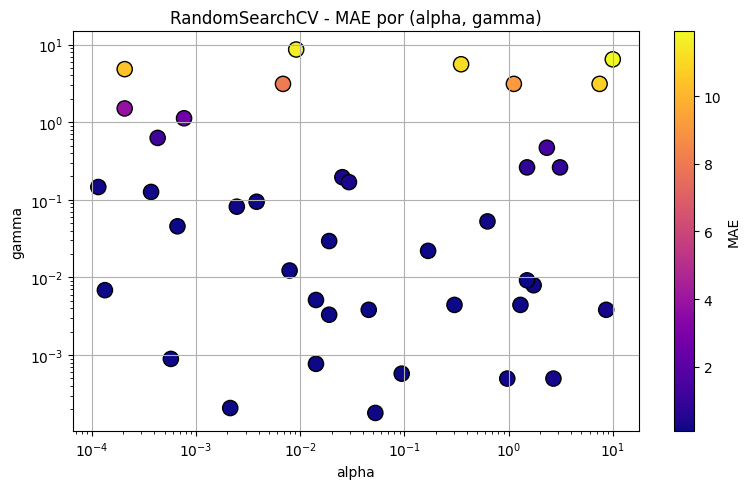

In [ ]:
results_random = random.cv_results_
rand_alphas = results_random['param_model__alpha'].data
rand_gammas = results_random['param_model__gamma'].data
rand_maes = -results_random['mean_test_score']

plt.figure(figsize=(8, 5))
sc = plt.scatter(rand_alphas, rand_gammas, c=rand_maes, cmap='plasma', s=120, edgecolors='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("alpha")
plt.ylabel("gamma")
plt.title("RandomSearchCV - MAE por (alpha, gamma)")
plt.colorbar(sc, label='MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


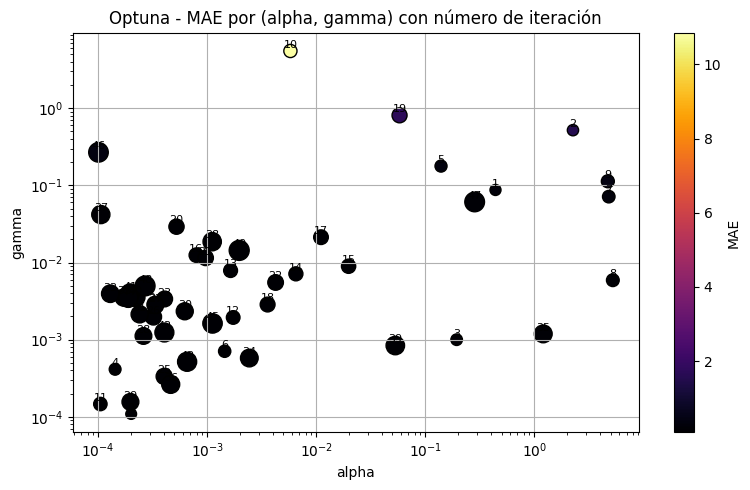

In [ ]:
optuna_trials = [t for t in study.trials if t.value is not None and 'gamma' in t.params]

optuna_alphas = [t.params['alpha'] for t in optuna_trials]
optuna_gammas = [t.params['gamma'] for t in optuna_trials]
optuna_maes = [t.value for t in optuna_trials]

plt.figure(figsize=(8, 5))
sc = plt.scatter(optuna_alphas, optuna_gammas, c=optuna_maes, cmap='inferno',
                 s=[60 + i*3 for i in range(len(optuna_alphas))], edgecolors='k')

for i, (a, g) in enumerate(zip(optuna_alphas, optuna_gammas)):
    plt.text(a, g * 1.1, str(i), fontsize=8, ha='center')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("alpha")
plt.ylabel("gamma")
plt.title("Optuna - MAE por (alpha, gamma) con número de iteración")
plt.colorbar(sc, label='MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


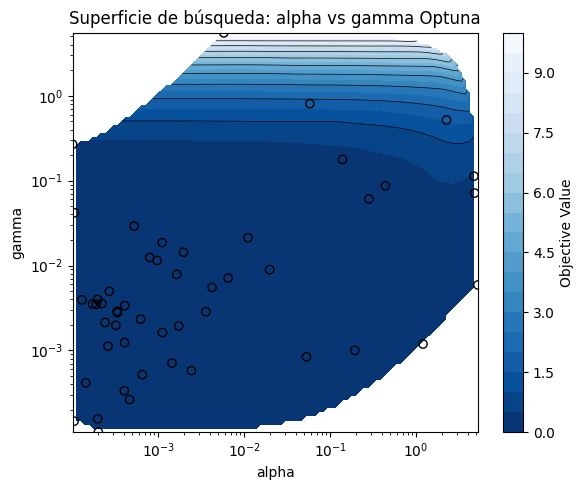

In [ ]:

# Filtrar trials válidos (con gamma)
optuna_trials = [t for t in study.trials if t.value is not None and 'gamma' in t.params]
alpha_vals = np.array([t.params['alpha'] for t in optuna_trials])
gamma_vals = np.array([t.params['gamma'] for t in optuna_trials])
mae_vals = np.array([t.value for t in optuna_trials])

# Crear grilla para interpolar
xi = np.logspace(np.log10(min(alpha_vals)), np.log10(max(alpha_vals)), 100)
yi = np.logspace(np.log10(min(gamma_vals)), np.log10(max(gamma_vals)), 100)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Interpolar valores de MAE
zi_grid = griddata((alpha_vals, gamma_vals), mae_vals, (xi_grid, yi_grid), method='cubic')

# Crear gráfico tipo superficie con colores invertidos
plt.figure(figsize=(6, 5))
contour = plt.contourf(xi_grid, yi_grid, zi_grid, levels=20, cmap='Blues_r')  # <- colormap invertido
contour_lines = plt.contour(xi_grid, yi_grid, zi_grid, levels=10, colors='black', linewidths=0.5)
plt.scatter(alpha_vals, gamma_vals, facecolors='none', edgecolors='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("alpha")
plt.ylabel("gamma")
plt.title("Superficie de búsqueda: alpha vs gamma Optuna")
plt.colorbar(contour, label='Objective Value')
plt.tight_layout()
plt.show()


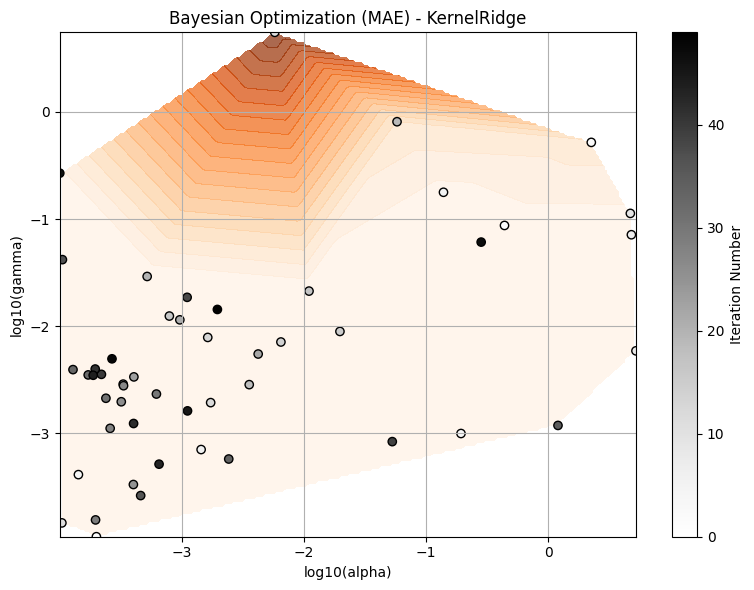

In [ ]:
# Extraer trials válidos con 'gamma' (es decir, kernel='rbf')
optuna_trials = [t for t in study.trials if t.value is not None and 'gamma' in t.params]
alpha_vals = np.array([t.params['alpha'] for t in optuna_trials])
gamma_vals = np.array([t.params['gamma'] for t in optuna_trials])
mae_vals = np.array([t.value for t in optuna_trials])
iterations = np.arange(len(mae_vals))

# Aplicar log10 para trabajar en escala logarítmica
log_alpha = np.log10(alpha_vals)
log_gamma = np.log10(gamma_vals)

# Crear grilla densa para interpolación de contorno
xi = np.linspace(log_alpha.min(), log_alpha.max(), 200)
yi = np.linspace(log_gamma.min(), log_gamma.max(), 200)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Interpolar valores de MAE para contorno de fondo
zi_grid = griddata((log_alpha, log_gamma), mae_vals, (xi_grid, yi_grid), method='linear')

# Dibujar el gráfico
plt.figure(figsize=(8, 6))

# Contorno interpolado del MAE
contour = plt.contourf(xi_grid, yi_grid, zi_grid, levels=20, cmap='Oranges', alpha=0.7)

# Puntos con color según número de iteración (más oscuro = más reciente)
sc = plt.scatter(log_alpha, log_gamma, c=iterations, cmap='Greys', edgecolors='black')

# Etiquetas y estética
plt.xlabel("log10(alpha)")
plt.ylabel("log10(gamma)")
plt.title("Bayesian Optimization (MAE) - KernelRidge")
cbar = plt.colorbar(sc)
cbar.set_label("Iteration Number")
plt.grid(True)
plt.tight_layout()
plt.show()


SGDRegressor

$$
\min_{w} \; \frac{1}{n} \sum_{i=1}^n \ell(y_i, x_i^T w) + \alpha R(w)
$$

$\ell $ : función de pérdida (`squared_loss`, `huber`, etc.)  
$R(w) $ : regularización (`l2`, `l1`, `elasticnet`)


In [ ]:
ytrain_log = np.log1p(ytrain)
ytest_log = np.log1p(ytest)


In [ ]:
def build_sgd_pipeline(params):
    model = SGDRegressor(
        alpha=params['alpha'],
        penalty=params['penalty'],
        loss=params['loss'],
        max_iter=5000,
        tol=1e-4,
        random_state=42
    )
    return Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', StandardScaler()),  # ✅ mejora para descenso gradiente
        ('model', model)
    ])


In [ ]:
pipeline_base = Pipeline([
    ('preprocessing', preprocessor),
    ('scaler', StandardScaler()),
    ('model', SGDRegressor(max_iter=5000, tol=1e-4, random_state=42))
])

param_grid = {
    'model__alpha': [1e-5, 1e-4, 1e-3],
    'model__penalty': ['l2', 'l1', 'elasticnet'],
    'model__loss': ['squared_error', 'huber']
}

grid = GridSearchCV(
    pipeline_base,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

grid.fit(Xtrain, ytrain_log)
best_params_grid = {k.replace('model__', ''): v for k, v in grid.best_params_.items()}
print("🔧 GridSearch - mejores params:", best_params_grid)


🔧 GridSearch - mejores params: {'alpha': 0.0001, 'loss': 'huber', 'penalty': 'elasticnet'}


In [ ]:
param_dist = {
    'model__alpha': np.logspace(-6, -2, 30),
    'model__penalty': ['l2', 'l1', 'elasticnet'],
    'model__loss': ['squared_error', 'huber', 'epsilon_insensitive']
}

random = RandomizedSearchCV(
    pipeline_base,
    param_distributions=param_dist,
    n_iter=40,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random.fit(Xtrain, ytrain_log)
best_params_random = {k.replace('model__', ''): v for k, v in random.best_params_.items()}
print("🔧 RandomSearch - mejores params:", best_params_random)


🔧 RandomSearch - mejores params: {'penalty': 'elasticnet', 'loss': 'huber', 'alpha': np.float64(0.0005736152510448681)}


In [ ]:
def objective_sgd(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2)
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    loss = trial.suggest_categorical('loss', ['squared_error', 'huber', 'epsilon_insensitive'])

    model = SGDRegressor(
        alpha=alpha,
        penalty=penalty,
        loss=loss,
        max_iter=5000,
        tol=1e-4,
        random_state=42
    )

    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    scores = cross_validate(
        pipeline, Xtrain, ytrain_log,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1
    )

    return -np.mean(scores['test_score'])

study = optuna.create_study(direction='minimize')
study.optimize(objective_sgd, n_trials=50)

best_params_optuna = study.best_params
print("🔧 Optuna - mejores params:", best_params_optuna)


[I 2025-05-23 00:52:06,665] A new study created in memory with name: no-name-3eeacd02-3ab3-414d-b148-75ed56195e24
<ipython-input-93-ac335e5b3b81>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2)
[I 2025-05-23 00:52:07,413] Trial 0 finished with value: 0.09914874639774399 and parameters: {'alpha': 2.677917236999979e-05, 'penalty': 'l2', 'loss': 'epsilon_insensitive'}. Best is trial 0 with value: 0.09914874639774399.
[I 2025-05-23 00:52:08,229] Trial 1 finished with value: 0.09580197559538473 and parameters: {'alpha': 1.6895990799553625e-05, 'penalty': 'elasticnet', 'loss': 'epsilon_insensitive'}. Best is trial 1 with value: 0.09580197559538473.
[I 2025-05-23 00:52:09,173] Trial 2 finished with value: 0.08951740113362462 and parameters: {'alpha': 0.00026579099541346006, 'penal

🔧 Optuna - mejores params: {'alpha': 5.8456393790994487e-05, 'penalty': 'l1', 'loss': 'huber'}


In [ ]:
def evaluar_modelo_cv_test(nombre, best_params):
    pipeline = build_sgd_pipeline(best_params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    maes, mses, r2s, mapes = [], [], [], []

    for train_idx, val_idx in kf.split(Xtrain):
        X_tr, X_val = Xtrain.iloc[train_idx], Xtrain.iloc[val_idx]
        y_tr, y_val = ytrain_log.iloc[train_idx], ytrain.iloc[val_idx]

        pipeline.fit(X_tr, y_tr)
        y_pred_val = np.expm1(pipeline.predict(X_val))

        maes.append(mean_absolute_error(y_val, y_pred_val))
        mses.append(mean_squared_error(y_val, y_pred_val))
        r2s.append(r2_score(y_val, y_pred_val))
        mapes.append(mean_absolute_percentage_error(y_val, y_pred_val))

    print(f"\n📈 Validación cruzada (5 folds) - {nombre}")
    print(f"MAE:  {np.mean(maes):.0f} ± {np.std(maes):.0f}")
    print(f"MSE:  {np.mean(mses):.0f} ± {np.std(mses):.0f}")
    print(f"R2:   {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
    print(f"MAPE: {np.mean(mapes):.4f} ± {np.std(mapes):.4f}")

    # Evaluación en test
    pipeline.fit(Xtrain, ytrain_log)
    ypred_test_log = pipeline.predict(Xtest)
    ypred_test = np.expm1(ypred_test_log)

    print(f"\n📊 Evaluación en test set - {nombre}")
    print(f"MAE:  {mean_absolute_error(ytest, ypred_test):.4f}")
    print(f"MSE:  {mean_squared_error(ytest, ypred_test):.4f}")
    print(f"R2:   {r2_score(ytest, ypred_test):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(ytest, ypred_test):.4f}")



In [ ]:
evaluar_modelo_cv_test("SGDRegressor - GridSearch", best_params_grid)
evaluar_modelo_cv_test("SGDRegressor - RandomSearch", best_params_random)
evaluar_modelo_cv_test("SGDRegressor - Optuna", best_params_optuna)



📈 Validación cruzada (5 folds) - SGDRegressor - GridSearch
MAE:  17647 ± 3450
MSE:  7248434219 ± 9971068074
R2:   -0.3079 ± 1.8713
MAPE: 0.1070 ± 0.0254

📊 Evaluación en test set - SGDRegressor - GridSearch
MAE:  15548.0666
MSE:  1191049580.4871
R2:   0.8306
MAPE: 0.0881

📈 Validación cruzada (5 folds) - SGDRegressor - RandomSearch
MAE:  17563 ± 3361
MSE:  6657451364 ± 9159812423
R2:   -0.2015 ± 1.7203
MAPE: 0.1064 ± 0.0247

📊 Evaluación en test set - SGDRegressor - RandomSearch
MAE:  15672.3542
MSE:  1175049178.3068
R2:   0.8328
MAPE: 0.0884

📈 Validación cruzada (5 folds) - SGDRegressor - Optuna
MAE:  17583 ± 3378
MSE:  6858739462 ± 9432321339
R2:   -0.2377 ± 1.7710
MAPE: 0.1066 ± 0.0249

📊 Evaluación en test set - SGDRegressor - Optuna
MAE:  15605.1057
MSE:  1179882069.7432
R2:   0.8322
MAPE: 0.0883


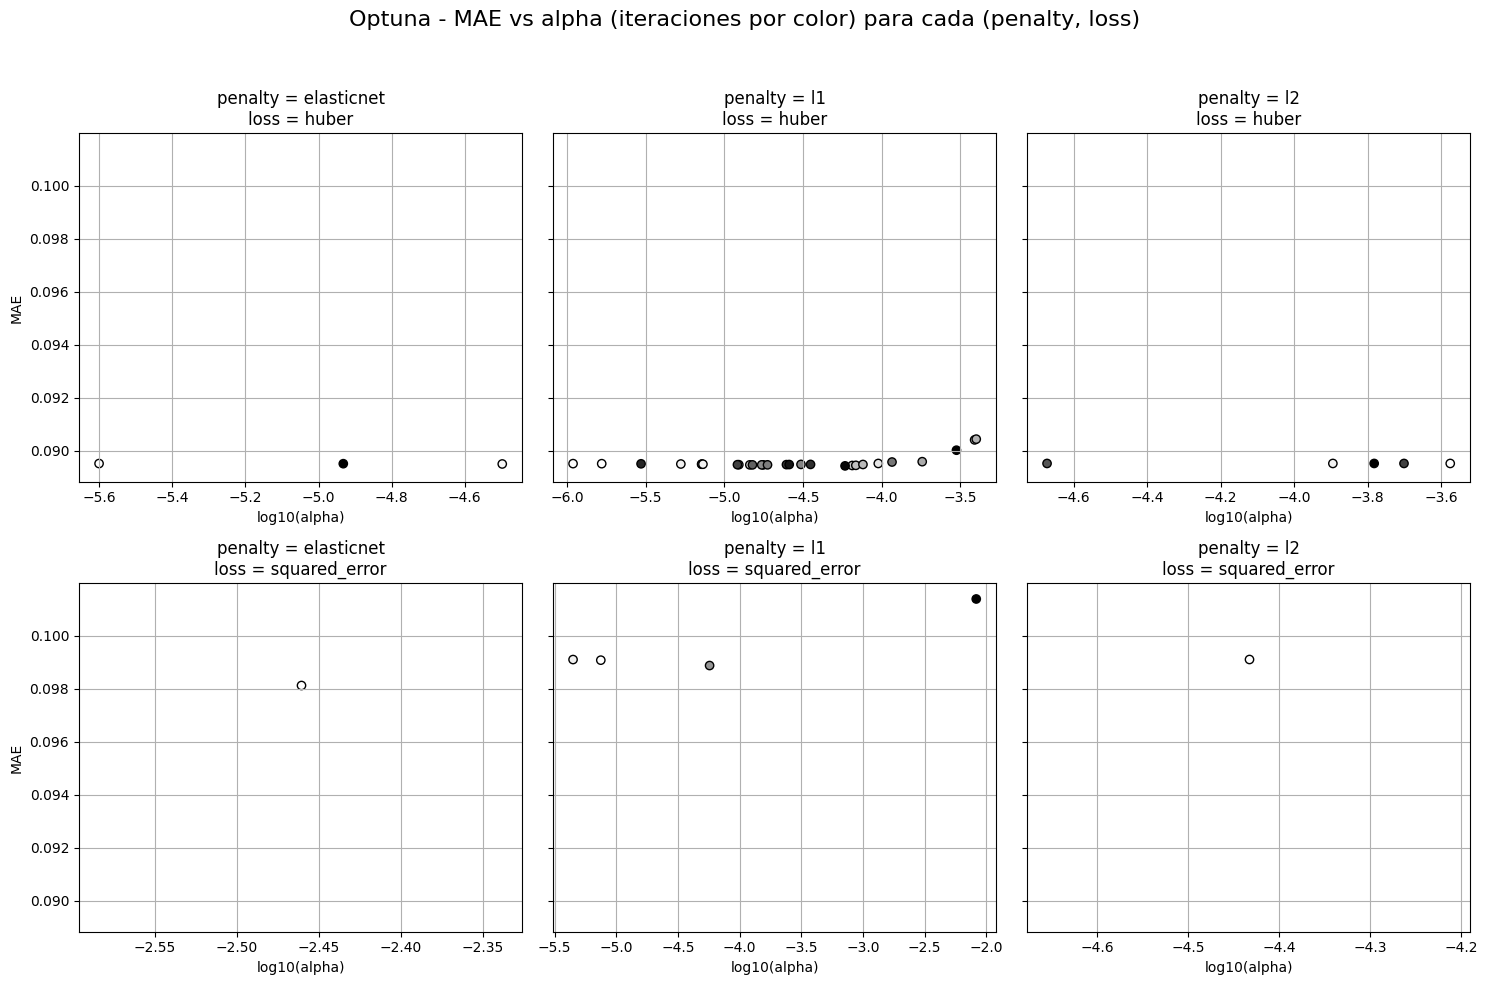

In [ ]:
optuna_trials = [t for t in study.trials if t.value is not None]
alphas_o = [np.log10(t.params['alpha']) for t in optuna_trials]
penalties_o = [t.params['penalty'] for t in optuna_trials]
losses_o = [t.params['loss'] for t in optuna_trials]
maes_o = [t.value for t in optuna_trials]
iterations = np.arange(len(maes_o))

fig, axes = plt.subplots(len(loss_list), len(penalty_list), figsize=(15, 10), sharey=True)

for i, loss in enumerate(loss_list):
    for j, penalty in enumerate(penalty_list):
        ax = axes[i, j]
        mask = [(l == loss and p == penalty) for l, p in zip(losses_o, penalties_o)]
        ax.scatter(np.array(alphas_o)[mask], np.array(maes_o)[mask],
                   c=np.array(iterations)[mask], cmap='Greys', edgecolors='black')
        ax.set_title(f"penalty = {penalty}\nloss = {loss}")
        ax.set_xlabel("log10(alpha)")
        if j == 0:
            ax.set_ylabel("MAE")
        ax.grid(True)

plt.suptitle("Optuna - MAE vs alpha (iteraciones por color) para cada (penalty, loss)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


BayessianRidge

$$
\min_{w} \; \alpha \| Xw - y \|_2^2 + \lambda \| w \|_2^2
$$

> Solución MAP bajo prior gaussiano sobre $$w \sim \mathcal{N}(0, \lambda^{-1} I) $$


In [ ]:
ytrain_log = np.log1p(ytrain)
ytest_log = np.log1p(ytest)


In [ ]:
def build_bayes_pipeline(params):
    model = BayesianRidge(
        alpha_1=params['alpha_1'],
        alpha_2=params['alpha_2'],
        lambda_1=params['lambda_1'],
        lambda_2=params['lambda_2']
    )
    return Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', StandardScaler()),
        ('model', model)
    ])


In [ ]:
pipeline_base = Pipeline([
    ('preprocessing', preprocessor),
    ('scaler', StandardScaler()),
    ('model', BayesianRidge())
])

param_grid = {
    'model__alpha_1': [1e-6, 1e-5, 1e-4],
    'model__alpha_2': [1e-6, 1e-5, 1e-4],
    'model__lambda_1': [1e-6, 1e-5, 1e-4],
    'model__lambda_2': [1e-6, 1e-5, 1e-4]
}

grid = GridSearchCV(
    pipeline_base,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

grid.fit(Xtrain, ytrain_log)
best_params_grid = {k.replace('model__', ''): v for k, v in grid.best_params_.items()}
print("🔧 GridSearch - mejores params:", best_params_grid)


🔧 GridSearch - mejores params: {'alpha_1': 1e-06, 'alpha_2': 0.0001, 'lambda_1': 0.0001, 'lambda_2': 1e-06}


In [ ]:
param_dist = {
    'model__alpha_1': np.logspace(-8, -4, 50),
    'model__alpha_2': np.logspace(-8, -4, 50),
    'model__lambda_1': np.logspace(-8, -4, 50),
    'model__lambda_2': np.logspace(-8, -4, 50)
}

random = RandomizedSearchCV(
    pipeline_base,
    param_distributions=param_dist,
    n_iter=40,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random.fit(Xtrain, ytrain_log)
best_params_random = {k.replace('model__', ''): v for k, v in random.best_params_.items()}
print("🔧 RandomSearch - mejores params:", best_params_random)


🔧 RandomSearch - mejores params: {'lambda_2': np.float64(7.906043210907701e-08), 'lambda_1': np.float64(8.286427728546843e-05), 'alpha_2': np.float64(4.71486636345739e-05), 'alpha_1': np.float64(5.4286754393238595e-08)}


In [ ]:
def objective_bayes(trial):
    alpha_1 = trial.suggest_loguniform('alpha_1', 1e-8, 1e-4)
    alpha_2 = trial.suggest_loguniform('alpha_2', 1e-8, 1e-4)
    lambda_1 = trial.suggest_loguniform('lambda_1', 1e-8, 1e-4)
    lambda_2 = trial.suggest_loguniform('lambda_2', 1e-8, 1e-4)

    model = BayesianRidge(
        alpha_1=alpha_1,
        alpha_2=alpha_2,
        lambda_1=lambda_1,
        lambda_2=lambda_2
    )

    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    scores = cross_validate(
        pipeline, Xtrain, ytrain_log,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1
    )

    return -np.mean(scores['test_score'])

study = optuna.create_study(direction='minimize')
study.optimize(objective_bayes, n_trials=50)

best_params_optuna = study.best_params
print("🔧 Optuna - mejores params:", best_params_optuna)


[I 2025-05-23 01:47:07,706] A new study created in memory with name: no-name-e4d2b0ef-0b8d-45e7-b282-63d18c685e47
<ipython-input-105-e363393309dc>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha_1 = trial.suggest_loguniform('alpha_1', 1e-8, 1e-4)
<ipython-input-105-e363393309dc>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha_2 = trial.suggest_loguniform('alpha_2', 1e-8, 1e-4)
<ipython-input-105-e363393309dc>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_1 = trial.suggest_loguniform('lamb

🔧 Optuna - mejores params: {'alpha_1': 8.029352557192187e-07, 'alpha_2': 9.048545986331438e-05, 'lambda_1': 7.755489739577756e-07, 'lambda_2': 2.703114321099037e-08}


In [ ]:
def evaluar_modelo_cv_test(nombre, best_params):
    pipeline = build_bayes_pipeline(best_params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    maes, mses, r2s, mapes = [], [], [], []

    for train_idx, val_idx in kf.split(Xtrain):
        X_tr, X_val = Xtrain.iloc[train_idx], Xtrain.iloc[val_idx]
        y_tr, y_val = ytrain_log.iloc[train_idx], ytrain.iloc[val_idx]

        pipeline.fit(X_tr, y_tr)
        y_pred_val = np.expm1(pipeline.predict(X_val))

        maes.append(mean_absolute_error(y_val, y_pred_val))
        mses.append(mean_squared_error(y_val, y_pred_val))
        r2s.append(r2_score(y_val, y_pred_val))
        mapes.append(mean_absolute_percentage_error(y_val, y_pred_val))

    print(f"\n📈 Validación cruzada (5 folds) - {nombre}")
    print(f"MAE:  {np.mean(maes):.0f} ± {np.std(maes):.0f}")
    print(f"MSE:  {np.mean(mses):.0f} ± {np.std(mses):.0f}")
    print(f"R2:   {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
    print(f"MAPE: {np.mean(mapes):.4f} ± {np.std(mapes):.4f}")

    # Evaluación en test
    pipeline.fit(Xtrain, ytrain_log)
    ypred_test_log = pipeline.predict(Xtest)
    ypred_test = np.expm1(ypred_test_log)

    print(f"\n📊 Evaluación en test set - {nombre}")
    print(f"MAE:  {mean_absolute_error(ytest, ypred_test):.4f}")
    print(f"MSE:  {mean_squared_error(ytest, ypred_test):.4f}")
    print(f"R2:   {r2_score(ytest, ypred_test):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(ytest, ypred_test):.4f}")


In [ ]:
evaluar_modelo_cv_test("BayesianRidge - GridSearch", best_params_grid)
evaluar_modelo_cv_test("BayesianRidge - RandomSearch", best_params_random)
evaluar_modelo_cv_test("BayesianRidge - Optuna", best_params_optuna)



📈 Validación cruzada (5 folds) - BayesianRidge - GridSearch
MAE:  18604 ± 1967
MSE:  4694221940 ± 5959338286
R2:   0.1582 ± 1.1234
MAPE: 0.1098 ± 0.0171

📊 Evaluación en test set - BayesianRidge - GridSearch
MAE:  17645.3843
MSE:  1117111689.8002
R2:   0.8411
MAPE: 0.0962

📈 Validación cruzada (5 folds) - BayesianRidge - RandomSearch
MAE:  18604 ± 1967
MSE:  4694214762 ± 5959328150
R2:   0.1582 ± 1.1234
MAPE: 0.1098 ± 0.0171

📊 Evaluación en test set - BayesianRidge - RandomSearch
MAE:  17645.3800
MSE:  1117110553.1957
R2:   0.8411
MAPE: 0.0962

📈 Validación cruzada (5 folds) - BayesianRidge - Optuna
MAE:  18604 ± 1967
MSE:  4694214177 ± 5959327298
R2:   0.1582 ± 1.1234
MAPE: 0.1098 ± 0.0171

📊 Evaluación en test set - BayesianRidge - Optuna
MAE:  17645.3798
MSE:  1117110487.2149
R2:   0.8411
MAPE: 0.0962


Gráficas

In [ ]:
# Entrenar modelo en todo Xtrain
pipeline = build_bayes_pipeline(best_params_optuna)
pipeline.fit(Xtrain, ytrain_log)

# Extraer modelo entrenado
model = pipeline.named_steps['model']
feature_names = Xtrain.columns

# Coeficientes y desviaciones estándar
coefs = model.coef_
coef_stds = np.sqrt(np.diag(model.sigma_))  # incertidumbre en los coeficientes

# Gráfica
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(coefs)), coefs, yerr=coef_stds, fmt='o', ecolor='red', capsize=3)
plt.xticks(range(len(coefs)), feature_names, rotation=90)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Coeficientes del modelo BayesianRidge con incertidumbre")
plt.ylabel("Valor del coeficiente")
plt.xlabel("Características")
plt.tight_layout()
plt.show()


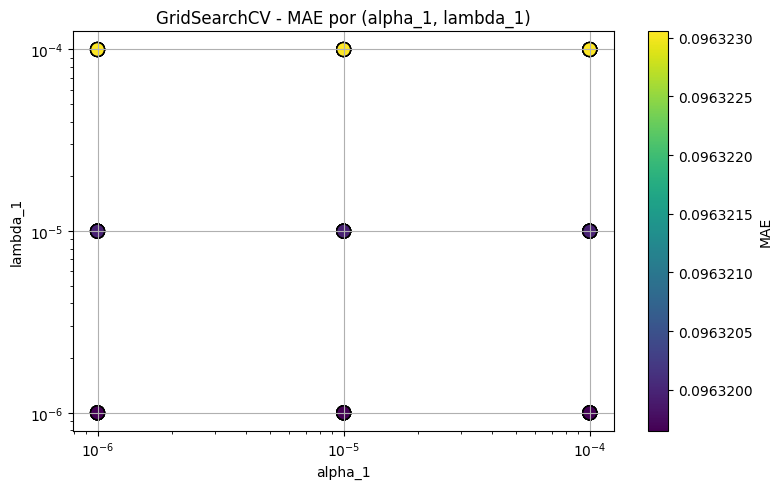

In [ ]:
results_grid = grid.cv_results_
params = results_grid['params']
maes = -results_grid['mean_test_score']

# Extraer parámetros
alpha_1 = [p['model__alpha_1'] for p in params]
lambda_1 = [p['model__lambda_2'] for p in params]

plt.figure(figsize=(8, 5))
sc = plt.scatter(alpha_1, lambda_1, c=maes, cmap='viridis', s=100, edgecolors='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("alpha_1")
plt.ylabel("lambda_1")
plt.title("GridSearchCV - MAE por (alpha_1, lambda_1)")
plt.colorbar(sc, label='MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


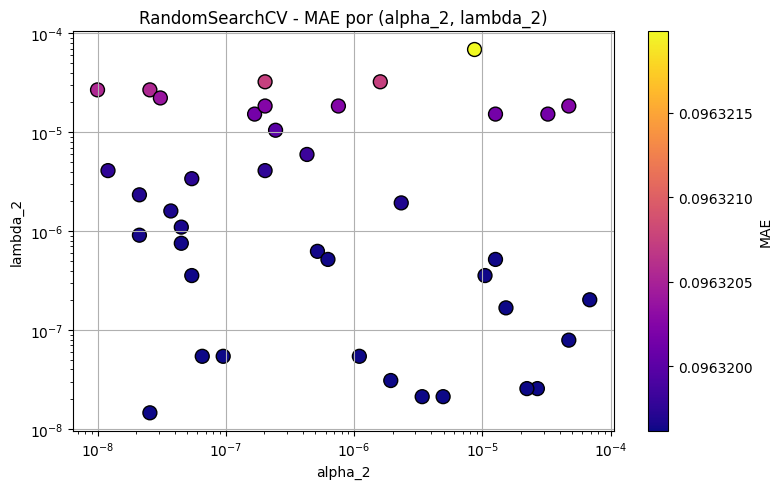

In [ ]:
results_random = random.cv_results_
params_r = results_random['params']
maes_r = -results_random['mean_test_score']

alpha_2 = [p['model__alpha_2'] for p in params_r]
lambda_2 = [p['model__lambda_2'] for p in params_r]

plt.figure(figsize=(8, 5))
sc = plt.scatter(alpha_2, lambda_2, c=maes_r, cmap='plasma', s=100, edgecolors='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("alpha_2")
plt.ylabel("lambda_2")
plt.title("RandomSearchCV - MAE por (alpha_2, lambda_2)")
plt.colorbar(sc, label='MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


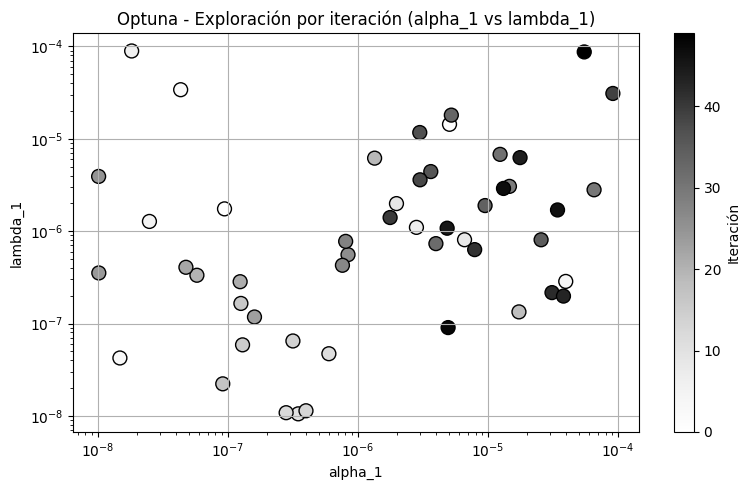

In [ ]:
optuna_trials = [t for t in study.trials if t.value is not None]
alpha1_o = [t.params['alpha_1'] for t in optuna_trials]
lambda1_o = [t.params['lambda_1'] for t in optuna_trials]
iterations = np.arange(len(optuna_trials))

plt.figure(figsize=(8, 5))
sc = plt.scatter(alpha1_o, lambda1_o, c=iterations, cmap='Greys', s=100, edgecolors='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("alpha_1")
plt.ylabel("lambda_1")
plt.title("Optuna - Exploración por iteración (alpha_1 vs lambda_1)")
plt.colorbar(sc, label='Iteración')
plt.grid(True)
plt.tight_layout()
plt.show()


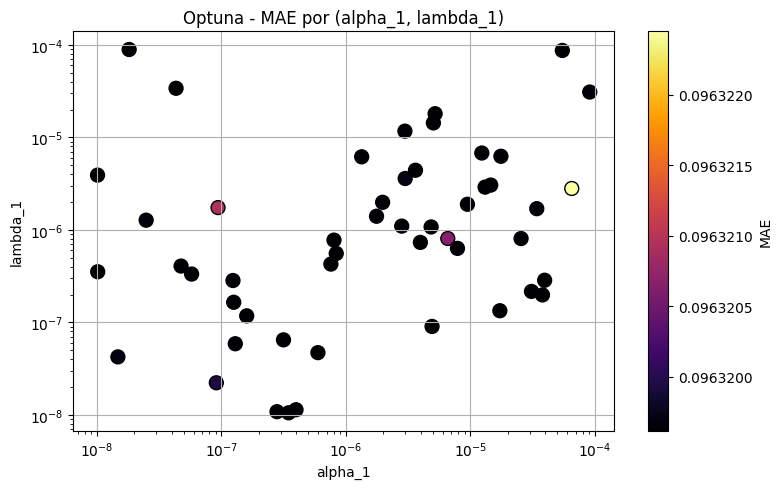

In [ ]:
# Extraer trials válidos de Optuna
optuna_trials = [t for t in study.trials if t.value is not None]
alpha1_o = [t.params['alpha_1'] for t in optuna_trials]
lambda1_o = [t.params['lambda_1'] for t in optuna_trials]
mae_vals = [t.value for t in optuna_trials]  # valor objetivo (MAE)

plt.figure(figsize=(8, 5))
sc = plt.scatter(alpha1_o, lambda1_o, c=mae_vals, cmap='inferno', s=100, edgecolors='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("alpha_1")
plt.ylabel("lambda_1")
plt.title("Optuna - MAE por (alpha_1, lambda_1)")
plt.colorbar(sc, label='MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


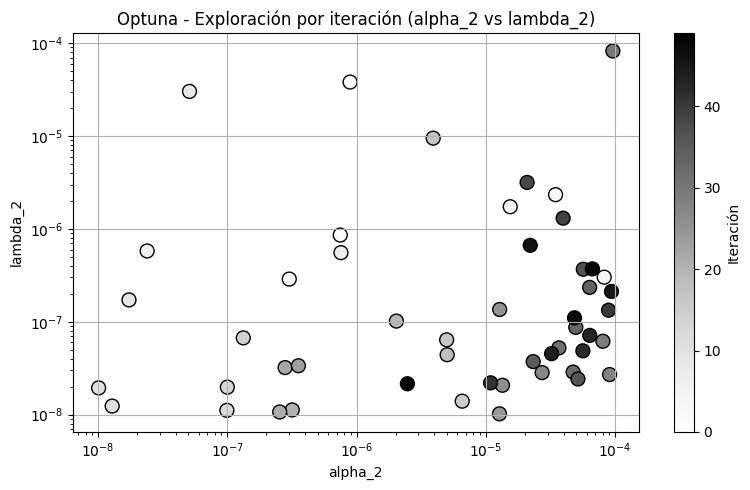

In [ ]:
optuna_trials = [t for t in study.trials if t.value is not None]
alpha1_o = [t.params['alpha_2'] for t in optuna_trials]
lambda1_o = [t.params['lambda_2'] for t in optuna_trials]
iterations = np.arange(len(optuna_trials))

plt.figure(figsize=(8, 5))
sc = plt.scatter(alpha1_o, lambda1_o, c=iterations, cmap='Greys', s=100, edgecolors='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("alpha_2")
plt.ylabel("lambda_2")
plt.title("Optuna - Exploración por iteración (alpha_2 vs lambda_2)")
plt.colorbar(sc, label='Iteración')
plt.grid(True)
plt.tight_layout()
plt.show()

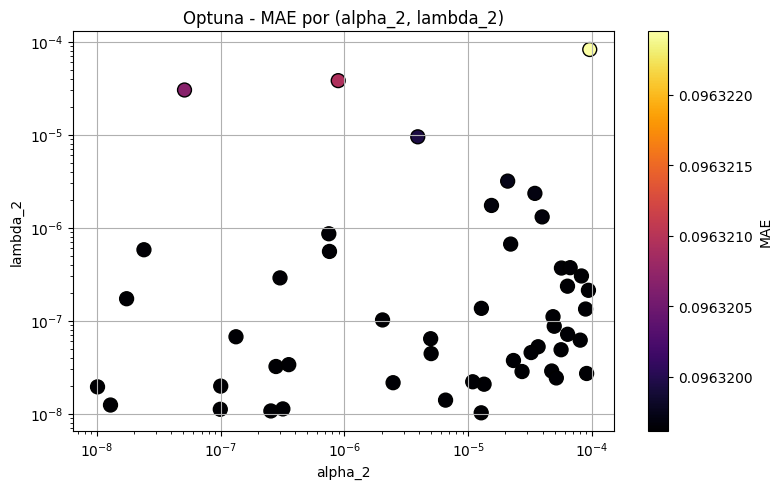

In [ ]:
# Extraer trials válidos de Optuna
optuna_trials = [t for t in study.trials if t.value is not None]
alpha1_o = [t.params['alpha_2'] for t in optuna_trials]
lambda1_o = [t.params['lambda_2'] for t in optuna_trials]
mae_vals = [t.value for t in optuna_trials]  # valor objetivo (MAE)

plt.figure(figsize=(8, 5))
sc = plt.scatter(alpha1_o, lambda1_o, c=mae_vals, cmap='inferno', s=100, edgecolors='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("alpha_2")
plt.ylabel("lambda_2")
plt.title("Optuna - MAE por (alpha_2, lambda_2)")
plt.colorbar(sc, label='MAE')
plt.grid(True)
plt.tight_layout()
plt.show()

GPR

$$
\log p(y | X) = -\frac{1}{2} y^T (K + \sigma^2 I)^{-1} y - \frac{1}{2} \log |K + \sigma^2 I| - \frac{n}{2} \log(2\pi)
$$

> Maximizar la log-verosimilitud marginal respecto a hiperparámetros del kernel


In [ ]:
ytrain_log = np.log1p(ytrain)
ytest_log = np.log1p(ytest)


In [ ]:
def build_gpr_pipeline(kernel):
    return Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', MinMaxScaler()),
        ('model', GaussianProcessRegressor(kernel=kernel, normalize_y=True))
    ])


In [ ]:
pipeline_base = Pipeline([
    ('preprocessing', preprocessor),
    ('scaler', MinMaxScaler()),
    ('model', GaussianProcessRegressor(normalize_y=True))
])

param_grid = {
    'model__kernel': [
        C(1.0, (0.5, 2.0)) * RBF(length_scale=1.0),
        C(1.0, (0.5, 2.0)) * RBF(length_scale=2.0)
    ]
}

grid = GridSearchCV(
    pipeline_base,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

grid.fit(Xtrain, ytrain_log)
best_kernel_grid = grid.best_params_['model__kernel']
print("🔧 GridSearch - mejor kernel:", best_kernel_grid)


🔧 GridSearch - mejor kernel: 1**2 * RBF(length_scale=1)


In [ ]:
kernel_list = [
    C(np.random.uniform(0.5, 1.5)) * RBF(length_scale=np.random.uniform(0.5, 4.0))
    for _ in range(5)
]

param_dist = {'model__kernel': kernel_list}

random = RandomizedSearchCV(
    pipeline_base,
    param_distributions=param_dist,
    n_iter=5,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random.fit(Xtrain, ytrain_log)
best_kernel_random = random.best_params_['model__kernel']
print("🔧 RandomSearch - mejor kernel:", best_kernel_random)


🔧 RandomSearch - mejor kernel: 0.888**2 * RBF(length_scale=1.65)


In [ ]:
def objective_gpr(trial):
    length_scale = trial.suggest_uniform("length_scale", 0.5, 4.0)
    constant_value = trial.suggest_uniform("constant_value", 0.5, 2.0)

    kernel = C(constant_value) * RBF(length_scale)
    pipeline = build_gpr_pipeline(kernel)

    scores = cross_validate(
        pipeline, Xtrain, ytrain_log,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1
    )

    return -np.mean(scores['test_score'])

study = optuna.create_study(direction='minimize')
study.optimize(objective_gpr, n_trials=5)

best_kernel_optuna = C(study.best_params["constant_value"]) * RBF(study.best_params["length_scale"])
print("🔧 Optuna - mejor kernel:", best_kernel_optuna)


[I 2025-05-23 02:23:31,687] A new study created in memory with name: no-name-c2d498d2-4f6b-4024-a0f8-49ecd17b2ec0
<ipython-input-127-b78c9aa0bc63>:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  length_scale = trial.suggest_uniform("length_scale", 0.5, 4.0)
<ipython-input-127-b78c9aa0bc63>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  constant_value = trial.suggest_uniform("constant_value", 0.5, 2.0)
[I 2025-05-23 02:24:39,653] Trial 0 finished with value: 0.30759392817670833 and parameters: {'length_scale': 3.7875373628063604, 'constant_value': 1.8251084083313933}. Best is trial 0 with value: 0.30759392817670833.
[I 2025-05-23 02:25:48,931] Trial 1 finished with value: 0.30759392817670833 and paramet

🔧 Optuna - mejor kernel: 0.778**2 * RBF(length_scale=1.95)


In [ ]:
def evaluar_modelo_cv_test(nombre, kernel):
    pipeline = build_gpr_pipeline(kernel)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    maes, mses, r2s, mapes = [], [], [], []

    for train_idx, val_idx in kf.split(Xtrain):
        X_tr, X_val = Xtrain.iloc[train_idx], Xtrain.iloc[val_idx]
        y_tr, y_val = ytrain_log.iloc[train_idx], ytrain.iloc[val_idx]

        pipeline.fit(X_tr, y_tr)
        y_pred_val = np.expm1(pipeline.predict(X_val))

        maes.append(mean_absolute_error(y_val, y_pred_val))
        mses.append(mean_squared_error(y_val, y_pred_val))
        r2s.append(r2_score(y_val, y_pred_val))
        mapes.append(mean_absolute_percentage_error(y_val, y_pred_val))

    print(f"\n📈 Validación cruzada (5 folds) - {nombre}")
    print(f"MAE:  {np.mean(maes):.0f} ± {np.std(maes):.0f}")
    print(f"MSE:  {np.mean(mses):.0f} ± {np.std(mses):.0f}")
    print(f"R2:   {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
    print(f"MAPE: {np.mean(mapes):.4f} ± {np.std(mapes):.4f}")

    # Evaluación en test
    pipeline.fit(Xtrain, ytrain_log)
    ypred_test = np.expm1(pipeline.predict(Xtest))

    print(f"\n📊 Evaluación en test set - {nombre}")
    print(f"MAE:  {mean_absolute_error(ytest, ypred_test):.4f}")
    print(f"MSE:  {mean_squared_error(ytest, ypred_test):.4f}")
    print(f"R2:   {r2_score(ytest, ypred_test):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(ytest, ypred_test):.4f}")



In [ ]:
evaluar_modelo_cv_test("GaussianProcess - GridSearch", best_kernel_grid)
evaluar_modelo_cv_test("GaussianProcess - RandomSearch", best_kernel_random)
evaluar_modelo_cv_test("GaussianProcess - Optuna", best_kernel_optuna)



📈 Validación cruzada (5 folds) - GaussianProcess - GridSearch
MAE:  17891 ± 521
MSE:  822491735 ± 176171360
R2:   0.8647 ± 0.0259
MAPE: 0.1096 ± 0.0123

📊 Evaluación en test set - GaussianProcess - GridSearch
MAE:  17031.1851
MSE:  801105635.7519
R2:   0.8860
MAPE: 0.0977

📈 Validación cruzada (5 folds) - GaussianProcess - RandomSearch
MAE:  17891 ± 521
MSE:  822491772 ± 176171428
R2:   0.8647 ± 0.0259
MAPE: 0.1096 ± 0.0123

📊 Evaluación en test set - GaussianProcess - RandomSearch
MAE:  17031.1862
MSE:  801105811.8273
R2:   0.8860
MAPE: 0.0977

📈 Validación cruzada (5 folds) - GaussianProcess - Optuna
MAE:  40222 ± 17978
MSE:  4143101874 ± 2608522974
R2:   0.3093 ± 0.4333
MAPE: 0.2415 ± 0.1024

📊 Evaluación en test set - GaussianProcess - Optuna
MAE:  17031.1861
MSE:  801105795.6278
R2:   0.8860
MAPE: 0.0977


In [ ]:
def extraer_constant_rbf_params(kernel):
    """Extrae constant_value y length_scale de un kernel anidado, si existen."""
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

    if isinstance(kernel, C) and isinstance(kernel.k2, RBF):
        return kernel.k1.constant_value, kernel.k2.length_scale
    elif hasattr(kernel, 'get_params'):
        params = kernel.get_params()
        const = params.get('k1__constant_value') or params.get('constant_value')
        length = params.get('k2__length_scale') or params.get('length_scale')
        if const is not None and length is not None:
            return const, length
    return None, None


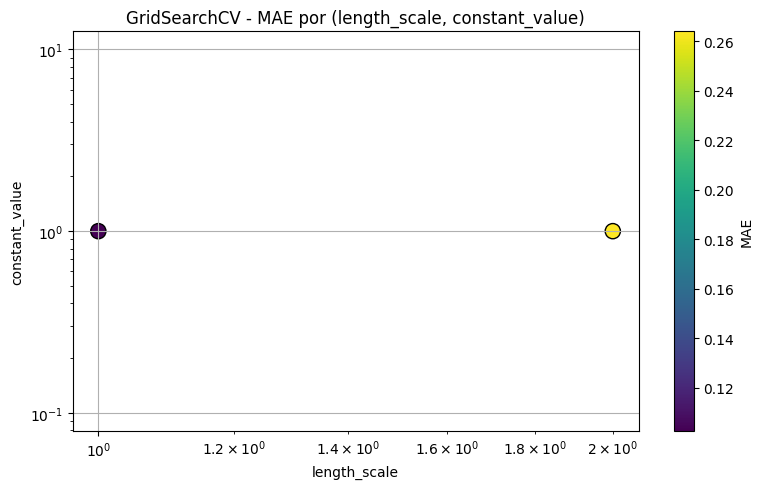

In [ ]:
lengths_g, constants_g, maes_g = [], [], []
for p, m in zip(grid.cv_results_['params'], -grid.cv_results_['mean_test_score']):
    kernel = p['model__kernel']
    const, length = extraer_constant_rbf_params(kernel)
    if const and length:
        constants_g.append(const)
        lengths_g.append(length)
        maes_g.append(m)

if lengths_g:
    plt.figure(figsize=(8, 5))
    sc = plt.scatter(lengths_g, constants_g, c=maes_g, cmap='viridis', s=120, edgecolors='k')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("length_scale")
    plt.ylabel("constant_value")
    plt.title("GridSearchCV - MAE por (length_scale, constant_value)")
    plt.colorbar(sc, label='MAE')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No se encontraron kernels válidos en GridSearchCV.")


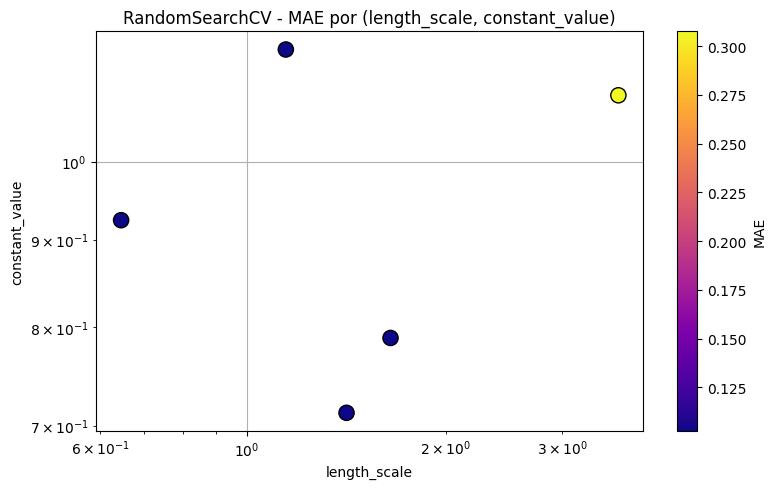

In [ ]:
lengths_r, constants_r, maes_r = [], [], []
for p, m in zip(random.cv_results_['params'], -random.cv_results_['mean_test_score']):
    kernel = p['model__kernel']
    const, length = extraer_constant_rbf_params(kernel)
    if const and length:
        constants_r.append(const)
        lengths_r.append(length)
        maes_r.append(m)

if lengths_r:
    plt.figure(figsize=(8, 5))
    sc = plt.scatter(lengths_r, constants_r, c=maes_r, cmap='plasma', s=120, edgecolors='k')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("length_scale")
    plt.ylabel("constant_value")
    plt.title("RandomSearchCV - MAE por (length_scale, constant_value)")
    plt.colorbar(sc, label='MAE')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No se encontraron kernels válidos en RandomSearchCV.")


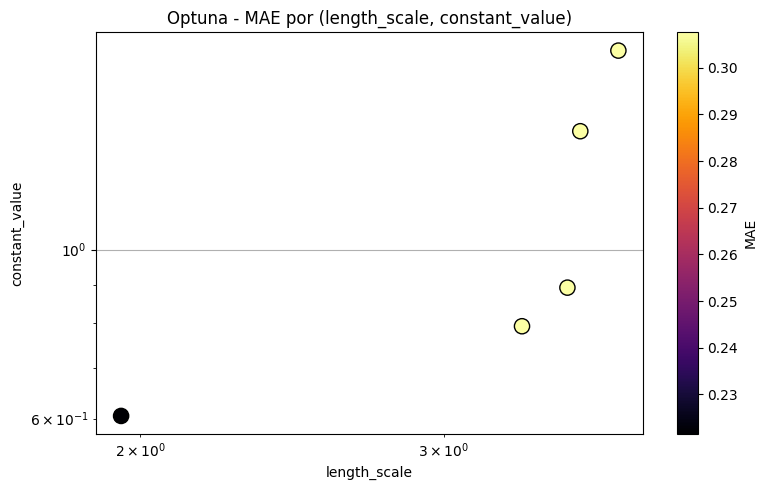

In [ ]:
lengths_o = [t.params['length_scale'] for t in study.trials if t.value is not None]
constants_o = [t.params['constant_value'] for t in study.trials if t.value is not None]
maes_o = [t.value for t in study.trials if t.value is not None]

if lengths_o:
    plt.figure(figsize=(8, 5))
    sc = plt.scatter(lengths_o, constants_o, c=maes_o, cmap='inferno', s=120, edgecolors='k')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("length_scale")
    plt.ylabel("constant_value")
    plt.title("Optuna - MAE por (length_scale, constant_value)")
    plt.colorbar(sc, label='MAE')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay valores válidos en Optuna.")


RFR

Cada árbol $$h_t$$ minimiza:
$$
\sum_{i \in \text{nodo}} (y_i - \bar{y})^2
$$

La predicción es:
$$
\hat{y} = \frac{1}{T} \sum_{t=1}^T h_t(x)
$$


In [ ]:
ytrain_log = np.log1p(ytrain)
ytest_log = np.log1p(ytest)


In [ ]:
def build_rf_pipeline(params):
    model = RandomForestRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        random_state=42,
        n_jobs=-1
    )
    return Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])


In [ ]:
pipeline_base = Pipeline([
    ('preprocessing', preprocessor),
    ('scaler', MinMaxScaler()),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [6, 10, 14],
    'model__min_samples_split': [2, 3, 4]
}

grid = GridSearchCV(
    pipeline_base,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

grid.fit(Xtrain, ytrain_log)
best_params_grid = {k.replace('model__', ''): v for k, v in grid.best_params_.items()}
print("🔧 GridSearch - mejores params:", best_params_grid)


🔧 GridSearch - mejores params: {'max_depth': 14, 'min_samples_split': 3, 'n_estimators': 300}


In [ ]:
param_dist = {
    'model__n_estimators': np.arange(100, 351, 10),
    'model__max_depth': np.arange(5, 21, 2),
    'model__min_samples_split': [2, 3, 4, 5]
}

random = RandomizedSearchCV(
    pipeline_base,
    param_distributions=param_dist,
    n_iter=15,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random.fit(Xtrain, ytrain_log)
best_params_random = {k.replace('model__', ''): v for k, v in random.best_params_.items()}
print("🔧 RandomSearch - mejores params:", best_params_random)


🔧 RandomSearch - mejores params: {'n_estimators': np.int64(320), 'min_samples_split': 3, 'max_depth': np.int64(19)}


In [ ]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 350, step=10),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5)
    }

    pipeline = build_rf_pipeline(params)

    scores = cross_validate(
        pipeline, Xtrain, ytrain_log,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1
    )

    return -np.mean(scores['test_score'])

study = optuna.create_study(direction='minimize')
study.optimize(objective_rf, n_trials=15)

best_params_optuna = study.best_params
print("🔧 Optuna - mejores params:", best_params_optuna)


[I 2025-05-23 03:19:22,288] A new study created in memory with name: no-name-2be220c5-46ee-4689-9a48-650998264463
[I 2025-05-23 03:19:44,722] Trial 0 finished with value: 0.0945128262101773 and parameters: {'n_estimators': 190, 'max_depth': 12, 'min_samples_split': 4}. Best is trial 0 with value: 0.0945128262101773.
[I 2025-05-23 03:20:18,127] Trial 1 finished with value: 0.09530329924766336 and parameters: {'n_estimators': 330, 'max_depth': 10, 'min_samples_split': 3}. Best is trial 0 with value: 0.0945128262101773.
[I 2025-05-23 03:20:39,343] Trial 2 finished with value: 0.09549821999693317 and parameters: {'n_estimators': 190, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 0.0945128262101773.
[I 2025-05-23 03:20:55,267] Trial 3 finished with value: 0.10196039307355835 and parameters: {'n_estimators': 220, 'max_depth': 7, 'min_samples_split': 4}. Best is trial 0 with value: 0.0945128262101773.
[I 2025-05-23 03:21:17,983] Trial 4 finished with value: 0.094797423

🔧 Optuna - mejores params: {'n_estimators': 290, 'max_depth': 16, 'min_samples_split': 2}


In [ ]:
def evaluar_modelo_cv_test(nombre, best_params):
    pipeline = build_rf_pipeline(best_params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    maes, mses, r2s, mapes = [], [], [], []

    for train_idx, val_idx in kf.split(Xtrain):
        X_tr, X_val = Xtrain.iloc[train_idx], Xtrain.iloc[val_idx]
        y_tr, y_val = ytrain_log.iloc[train_idx], ytrain.iloc[val_idx]

        pipeline.fit(X_tr, y_tr)
        y_pred_val = np.expm1(pipeline.predict(X_val))

        maes.append(mean_absolute_error(y_val, y_pred_val))
        mses.append(mean_squared_error(y_val, y_pred_val))
        r2s.append(r2_score(y_val, y_pred_val))
        mapes.append(mean_absolute_percentage_error(y_val, y_pred_val))

    print(f"\n📈 Validación cruzada (5 folds) - {nombre}")
    print(f"MAE:  {np.mean(maes):.0f} ± {np.std(maes):.0f}")
    print(f"MSE:  {np.mean(mses):.0f} ± {np.std(mses):.0f}")
    print(f"R2:   {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
    print(f"MAPE: {np.mean(mapes):.4f} ± {np.std(mapes):.4f}")

    # Evaluación en test
    pipeline.fit(Xtrain, ytrain_log)
    ypred_test = np.expm1(pipeline.predict(Xtest))

    print(f"\n📊 Evaluación en test set - {nombre}")
    print(f"MAE:  {mean_absolute_error(ytest, ypred_test):.4f}")
    print(f"MSE:  {mean_squared_error(ytest, ypred_test):.4f}")
    print(f"R2:   {r2_score(ytest, ypred_test):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(ytest, ypred_test):.4f}")



In [ ]:
evaluar_modelo_cv_test("RandomForest - GridSearch", best_params_grid)
evaluar_modelo_cv_test("RandomForest - RandomSearch", best_params_random)
evaluar_modelo_cv_test("RandomForest - Optuna", best_params_optuna)



📈 Validación cruzada (5 folds) - RandomForest - GridSearch
MAE:  16661 ± 808
MSE:  810991297 ± 229351929
R2:   0.8661 ± 0.0364
MAPE: 0.0997 ± 0.0059

📊 Evaluación en test set - RandomForest - GridSearch
MAE:  15854.0568
MSE:  686432383.7860
R2:   0.9023
MAPE: 0.0875

📈 Validación cruzada (5 folds) - RandomForest - RandomSearch
MAE:  16649 ± 821
MSE:  809122589 ± 223402689
R2:   0.8664 ± 0.0354
MAPE: 0.0996 ± 0.0057

📊 Evaluación en test set - RandomForest - RandomSearch
MAE:  15752.3980
MSE:  677633895.9563
R2:   0.9036
MAPE: 0.0872

📈 Validación cruzada (5 folds) - RandomForest - Optuna
MAE:  16652 ± 783
MSE:  812819076 ± 227280969
R2:   0.8658 ± 0.0358
MAPE: 0.0995 ± 0.0057

📊 Evaluación en test set - RandomForest - Optuna
MAE:  15803.7180
MSE:  675856301.4599
R2:   0.9039
MAPE: 0.0874


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def graficar_exploracion_rf_3d(titulo, n_estimators, max_depths, min_splits, maes):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(n_estimators, max_depths, min_splits,
                    c=maes, cmap='viridis', s=60, edgecolors='k')

    # Encontrar mejor punto
    idx_best = np.argmin(maes)
    best_point = (n_estimators[idx_best], max_depths[idx_best], min_splits[idx_best])
    best_mae = maes[idx_best]

    # Dibujar estrella dorada
    ax.scatter(*best_point, color='gold', edgecolor='black', s=120, marker='*', label=f"Mejor MAE: {best_mae:.0f}")

    ax.set_xlabel("n_estimators")
    ax.set_ylabel("max_depth")
    ax.set_zlabel("min_samples_split")
    ax.set_title(titulo)

    cbar = fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label("MAE")
    ax.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
params = grid.cv_results_['params']
maes = -grid.cv_results_['mean_test_score']

n_estimators = [p['model__n_estimators'] for p in params]
max_depths = [p['model__max_depth'] for p in params]
min_splits = [p['model__min_samples_split'] for p in params]

graficar_exploracion_rf_3d("GridSearchCV - Espacio 3D de hiperparámetros", n_estimators, max_depths, min_splits, maes)


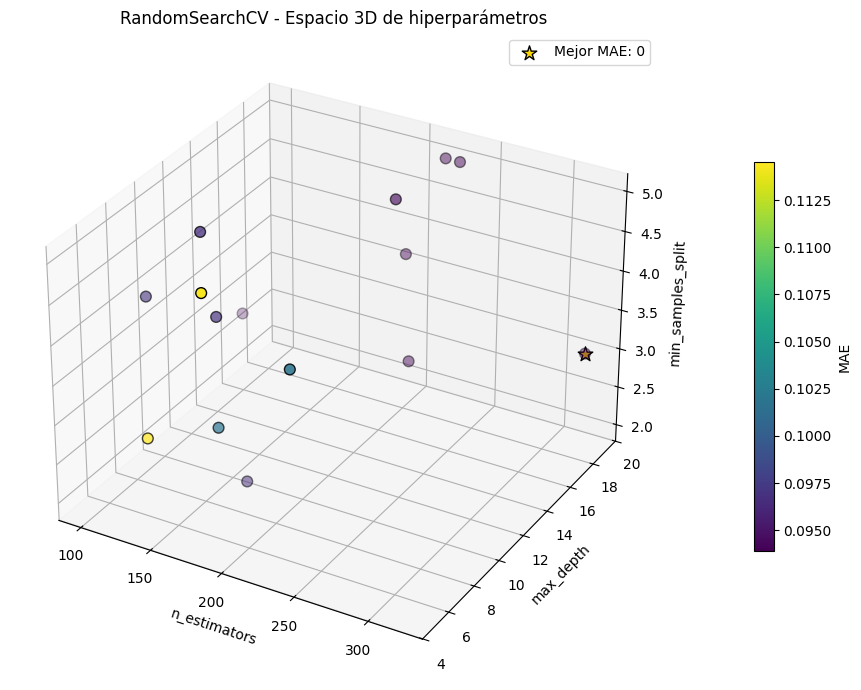

In [ ]:
params_r = random.cv_results_['params']
maes_r = -random.cv_results_['mean_test_score']

n_estimators_r = [p['model__n_estimators'] for p in params_r]
max_depths_r = [p['model__max_depth'] for p in params_r]
min_splits_r = [p['model__min_samples_split'] for p in params_r]

graficar_exploracion_rf_3d("RandomSearchCV - Espacio 3D de hiperparámetros", n_estimators_r, max_depths_r, min_splits_r, maes_r)


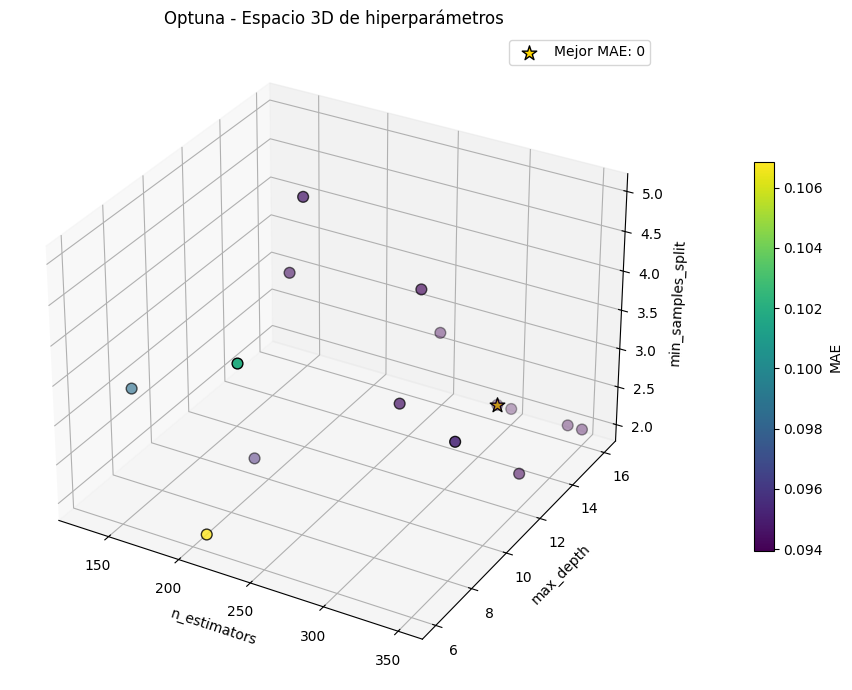

In [ ]:
optuna_trials = [t for t in study.trials if t.value is not None]

n_estimators_o = [t.params['n_estimators'] for t in optuna_trials]
max_depths_o = [t.params['max_depth'] for t in optuna_trials]
min_splits_o = [t.params['min_samples_split'] for t in optuna_trials]
maes_o = [t.value for t in optuna_trials]

graficar_exploracion_rf_3d("Optuna - Espacio 3D de hiperparámetros", n_estimators_o, max_depths_o, min_splits_o, maes_o)


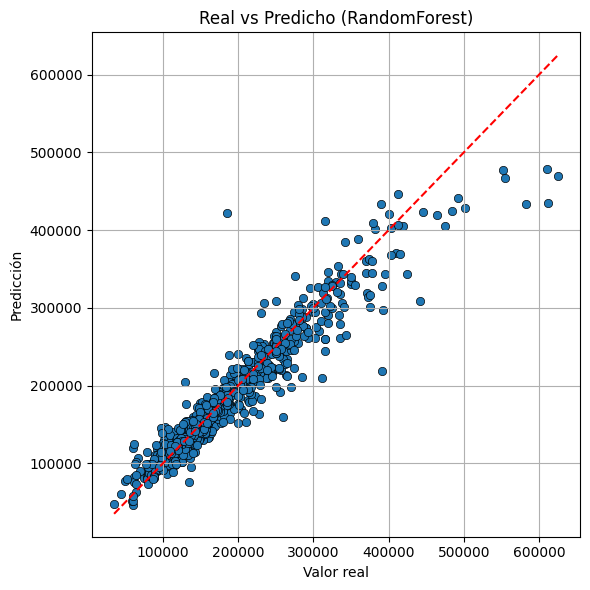

In [ ]:
import seaborn as sns

pipeline = build_rf_pipeline(best_params_optuna)
pipeline.fit(Xtrain, ytrain_log)
y_pred_test = np.expm1(pipeline.predict(Xtest))

plt.figure(figsize=(6,6))
sns.scatterplot(x=ytest, y=y_pred_test, edgecolor='k')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Real vs Predicho (RandomForest)")
plt.grid(True)
plt.tight_layout()
plt.show()


SVR

$$
\min_{w, \xi, \xi^*} \; \frac{1}{2} \| w \|^2 + C \sum_{i=1}^n (\xi_i + \xi_i^*) \\
\text{s.a.}
\begin{cases}
y_i - w^T \phi(x_i) - b \leq \epsilon + \xi_i \\\\
w^T \phi(x_i) + b - y_i \leq \epsilon + \xi_i^* \\\\
\xi_i, \xi_i^* \geq 0
\end{cases}
$$



In [ ]:
ytrain_log = np.log1p(ytrain)
ytest_log = np.log1p(ytest)


In [ ]:
def build_svr_pipeline(params):
    model = SVR(
        C=params['C'],
        epsilon=params['epsilon'],
        gamma=params['gamma'],
        kernel='rbf'
    )
    return Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])


In [ ]:
pipeline_base = Pipeline([
    ('preprocessing', preprocessor),
    ('scaler', MinMaxScaler()),
    ('model', SVR(kernel='rbf'))
])

param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__epsilon': [0.01, 0.1, 0.2, 0.3],
    'model__gamma': ['scale', 'auto', 0.01]
}

grid = GridSearchCV(
    pipeline_base,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

grid.fit(Xtrain, ytrain_log)
best_params_grid = {k.replace('model__', ''): v for k, v in grid.best_params_.items()}
print("🔧 GridSearch - mejores params:", best_params_grid)


🔧 GridSearch - mejores params: {'C': 10, 'epsilon': 0.01, 'gamma': 'auto'}


In [ ]:
param_dist = {
    'model__C': uniform(0.1, 200),
    'model__epsilon': uniform(0.01, 0.5),
    'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

random = RandomizedSearchCV(
    pipeline_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random.fit(Xtrain, ytrain_log)
best_params_random = {k.replace('model__', ''): v for k, v in random.best_params_.items()}
print("🔧 RandomSearch - mejores params:", best_params_random)


🔧 RandomSearch - mejores params: {'C': np.float64(36.46499344142013), 'epsilon': np.float64(0.1017022549267169), 'gamma': 0.01}


In [ ]:
def objective_svr(trial):
    params = {
        'C': trial.suggest_loguniform('C', 0.1, 200),
        'epsilon': trial.suggest_uniform('epsilon', 0.01, 0.5),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto', 0.001, 0.01, 0.1])
    }

    pipeline = build_svr_pipeline(params)

    scores = cross_validate(
        pipeline, Xtrain, ytrain_log,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1
    )

    return -np.mean(scores['test_score'])

study = optuna.create_study(direction='minimize')
study.optimize(objective_svr, n_trials=20)

best_params_optuna = study.best_params
print("🔧 Optuna - mejores params:", best_params_optuna)


[I 2025-05-23 03:48:41,324] A new study created in memory with name: no-name-1e1497ab-4c14-4578-b9ed-0feee4a154a5
<ipython-input-166-a07480202c2c>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 0.1, 200),
<ipython-input-166-a07480202c2c>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'epsilon': trial.suggest_uniform('epsilon', 0.01, 0.5),
[I 2025-05-23 03:48:42,114] Trial 0 finished with value: 0.1296985328207913 and parameters: {'C': 7.126932813617056, 'epsilon': 0.3549457847364696, 'gamma': 0.1}. Best is trial 0 with value: 0.1296985328207913.
[I 2025-05-23 03:48:42,981] Trial 1 finished with value: 0.11161139436428165 and parameters: {'C': 69.856

🔧 Optuna - mejores params: {'C': 20.96354335261751, 'epsilon': 0.10660786627495082, 'gamma': 'auto'}


In [ ]:
def evaluar_modelo_cv_test(nombre, best_params):
    pipeline = build_svr_pipeline(best_params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    maes, mses, r2s, mapes = [], [], [], []

    for train_idx, val_idx in kf.split(Xtrain):
        X_tr, X_val = Xtrain.iloc[train_idx], Xtrain.iloc[val_idx]
        y_tr, y_val = ytrain_log.iloc[train_idx], ytrain.iloc[val_idx]

        pipeline.fit(X_tr, y_tr)
        y_pred_val = np.expm1(pipeline.predict(X_val))

        maes.append(mean_absolute_error(y_val, y_pred_val))
        mses.append(mean_squared_error(y_val, y_pred_val))
        r2s.append(r2_score(y_val, y_pred_val))
        mapes.append(mean_absolute_percentage_error(y_val, y_pred_val))

    print(f"\n📈 Validación cruzada (5 folds) - {nombre}")
    print(f"MAE:  {np.mean(maes):.0f} ± {np.std(maes):.0f}")
    print(f"MSE:  {np.mean(mses):.0f} ± {np.std(mses):.0f}")
    print(f"R2:   {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
    print(f"MAPE: {np.mean(mapes):.4f} ± {np.std(mapes):.4f}")

    # Evaluación en test
    pipeline.fit(Xtrain, ytrain_log)
    ypred_test = np.expm1(pipeline.predict(Xtest))

    print(f"\n📊 Evaluación en test set - {nombre}")
    print(f"MAE:  {mean_absolute_error(ytest, ypred_test):.4f}")
    print(f"MSE:  {mean_squared_error(ytest, ypred_test):.4f}")
    print(f"R2:   {r2_score(ytest, ypred_test):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(ytest, ypred_test):.4f}")
    return ypred_test


In [ ]:
evaluar_modelo_cv_test("SVR - RandomSearch", best_params_random)
evaluar_modelo_cv_test("SVR - Optuna", best_params_optuna)
ypred_testsvr=evaluar_modelo_cv_test("SVR - GridSearch", best_params_grid)



📈 Validación cruzada (5 folds) - SVR - RandomSearch
MAE:  16177 ± 1932
MSE:  2779665969 ± 2993364602
R2:   0.5101 ± 0.5545
MAPE: 0.0976 ± 0.0159

📊 Evaluación en test set - SVR - RandomSearch
MAE:  14623.6169
MSE:  968146000.7460
R2:   0.8623
MAPE: 0.0831

📈 Validación cruzada (5 folds) - SVR - Optuna
MAE:  16141 ± 1709
MSE:  2457462888 ± 2563550834
R2:   0.5677 ± 0.4757
MAPE: 0.0974 ± 0.0150

📊 Evaluación en test set - SVR - Optuna
MAE:  14677.8424
MSE:  938365362.0602
R2:   0.8665
MAPE: 0.0834

📈 Validación cruzada (5 folds) - SVR - GridSearch
MAE:  15626 ± 2007
MSE:  3208408667 ± 3481683543
R2:   0.4366 ± 0.6347
MAPE: 0.0959 ± 0.0175

📊 Evaluación en test set - SVR - GridSearch
MAE:  14044.6115
MSE:  1310801243.1634
R2:   0.8135
MAPE: 0.0809


In [ ]:
ypred_testsvr = pd.DataFrame(ypred_testsvr)
ytest.to_csv("ytestsvr.csv", index=False, header=False)
ypred_testsvr.to_csv("ypred_testsvr.csv", index=False, header=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_optuna_surface(x_vals, y_vals, z_vals, xlabel, ylabel, title, star=True):
    # Convert categorical or mixed types
    x_vals = [str(x) if isinstance(x, str) else x for x in x_vals]
    y_vals = [str(y) if isinstance(y, str) else y for y in y_vals]

    def encode(val_list):
        unique_vals = sorted(set(val_list), key=str)
        encoding = {v: i for i, v in enumerate(unique_vals)}
        return [encoding[v] for v in val_list], encoding, unique_vals

    x_encoded, x_map, x_raw = encode(x_vals)
    y_encoded, y_map, y_raw = encode(y_vals)

    xi = np.linspace(min(x_encoded), max(x_encoded), 100)
    yi = np.linspace(min(y_encoded), max(y_encoded), 100)
    xi_grid, yi_grid = np.meshgrid(xi, yi)
    zi = griddata((x_encoded, y_encoded), z_vals, (xi_grid, yi_grid), method='cubic')

    plt.figure(figsize=(8, 6))
    cp = plt.contourf(xi_grid, yi_grid, zi, levels=20, cmap='Blues')
    plt.contour(xi_grid, yi_grid, zi, levels=10, colors='black', linewidths=0.5)
    plt.scatter(x_encoded, y_encoded, c='k', s=30, edgecolors='white', label='Evaluaciones')

    # ⭐ estrella dorada en el mínimo
    if star:
        idx_best = np.argmin(z_vals)
        plt.scatter(x_encoded[idx_best], y_encoded[idx_best], s=150, color='gold', marker='*', edgecolors='black', label='Mejor MAE')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.colorbar(cp, label="Objective Value (MAE)")

    # Etiquetas redondeadas
    xtick_locs = sorted(set(x_encoded))
    ytick_locs = sorted(set(y_encoded))

    xtick_labels = [f"{v:.2g}" if isinstance(v, float) else str(v) for v in x_raw]
    ytick_labels = [f"{v:.2g}" if isinstance(v, float) else str(v) for v in y_raw]

    plt.xticks(xtick_locs, xtick_labels, rotation=45)
    plt.yticks(ytick_locs, ytick_labels)
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
optuna_trials = [t for t in study.trials if t.value is not None]

Cs = [t.params['C'] for t in optuna_trials]
epsilons = [t.params['epsilon'] for t in optuna_trials]
gammas = [t.params['gamma'] for t in optuna_trials]
maes = [t.value for t in optuna_trials]


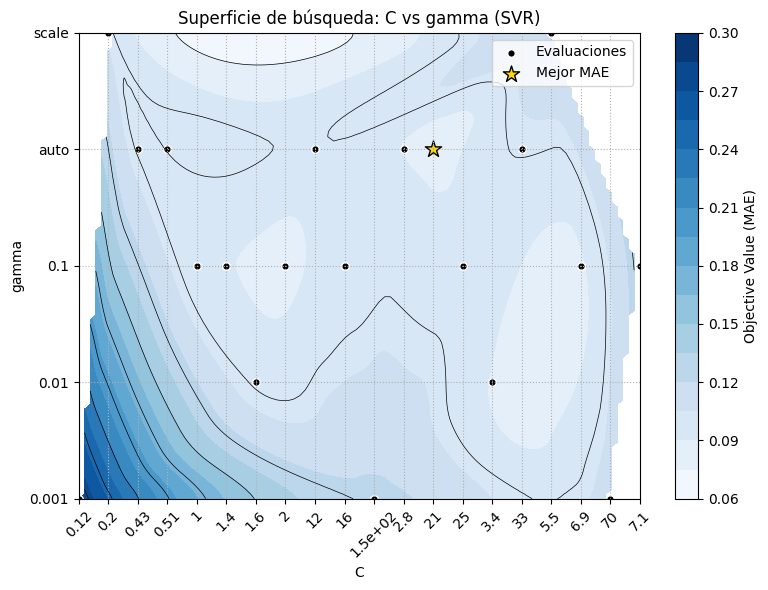

In [ ]:
plot_optuna_surface(
    x_vals=Cs,
    y_vals=gammas,
    z_vals=maes,
    xlabel="C",
    ylabel="gamma",
    title="Superficie de búsqueda: C vs gamma (SVR)"
)


In [ ]:
plot_optuna_surface(
    x_vals=Cs,
    y_vals=epsilons,
    z_vals=maes,
    xlabel="C",
    ylabel="epsilon",
    title="Superficie de búsqueda: C vs epsilon (SVR)"
)


In [ ]:
plot_optuna_surface(
    x_vals=gammas,
    y_vals=epsilons,
    z_vals=maes,
    xlabel="gamma",
    ylabel="epsilon",
    title="Superficie de búsqueda: gamma vs epsilon (SVR)"
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

def plot_optuna_log_surface(x_vals, y_vals, z_vals, iters, xlabel, ylabel, title):
    log_x = np.log10(x_vals)
    log_y = np.log10(y_vals)

    tri = Triangulation(log_x, log_y)

    fig, ax = plt.subplots(figsize=(9, 7))

    # Superficie MAE (sin contorno negro)
    surf = ax.tricontourf(tri, z_vals, levels=20, cmap='Blues')

    # Puntos: color por iteración
    sc = ax.scatter(log_x, log_y, c=iters, cmap='Greys', edgecolors='white', s=60)

    ax.set_xlabel(f"log10({xlabel})")
    ax.set_ylabel(f"log10({ylabel})")
    ax.set_title(title)

    # Colorbars
    cbar1 = fig.colorbar(surf, ax=ax, pad=0.02)
    cbar1.set_label("MAE")
    cbar2 = fig.colorbar(sc, ax=ax, pad=0.08)
    cbar2.set_label("Iteration Number")

    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
optuna_trials = [t for t in study.trials if t.value is not None and isinstance(t.params.get('gamma'), float)]

C_vals = np.array([t.params['C'] for t in optuna_trials])
gamma_vals = np.array([t.params['gamma'] for t in optuna_trials])
epsilon_vals = np.array([t.params['epsilon'] for t in optuna_trials])
maes = np.array([t.value for t in optuna_trials])
iters = np.array([t.number for t in optuna_trials])


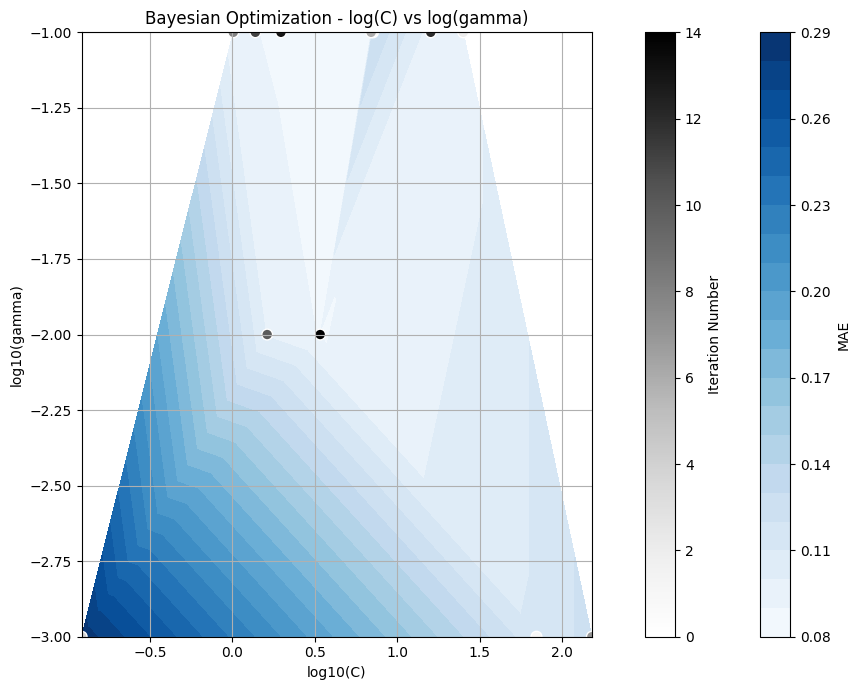

In [ ]:
plot_optuna_log_surface(
    x_vals=C_vals,
    y_vals=gamma_vals,
    z_vals=maes,
    iters=iters,
    xlabel="C",
    ylabel="gamma",
    title="Bayesian Optimization - log(C) vs log(gamma)"
)


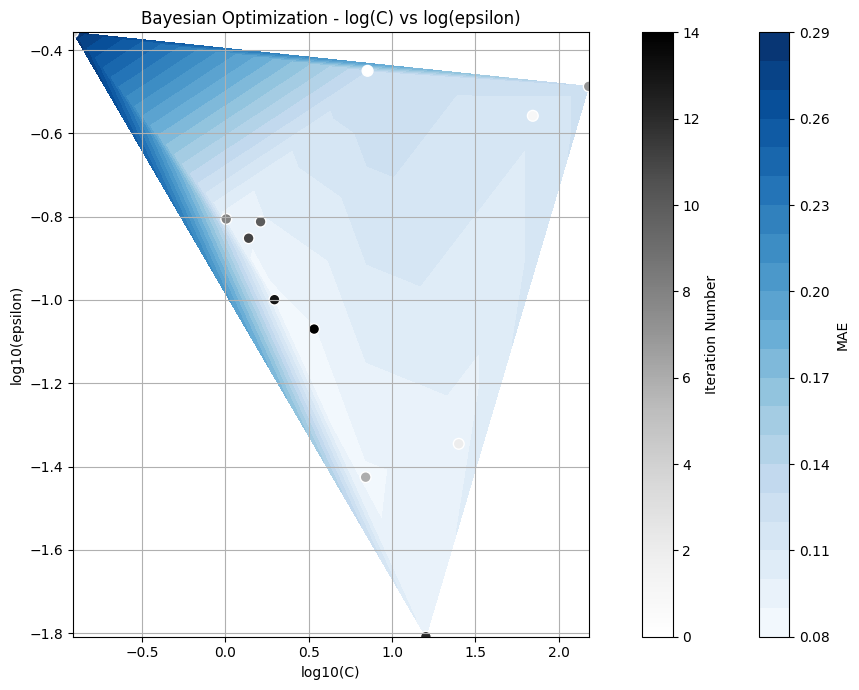

In [ ]:
plot_optuna_log_surface(
    x_vals=C_vals,
    y_vals=epsilon_vals,
    z_vals=maes,
    iters=iters,
    xlabel="C",
    ylabel="epsilon",
    title="Bayesian Optimization - log(C) vs log(epsilon)"
)


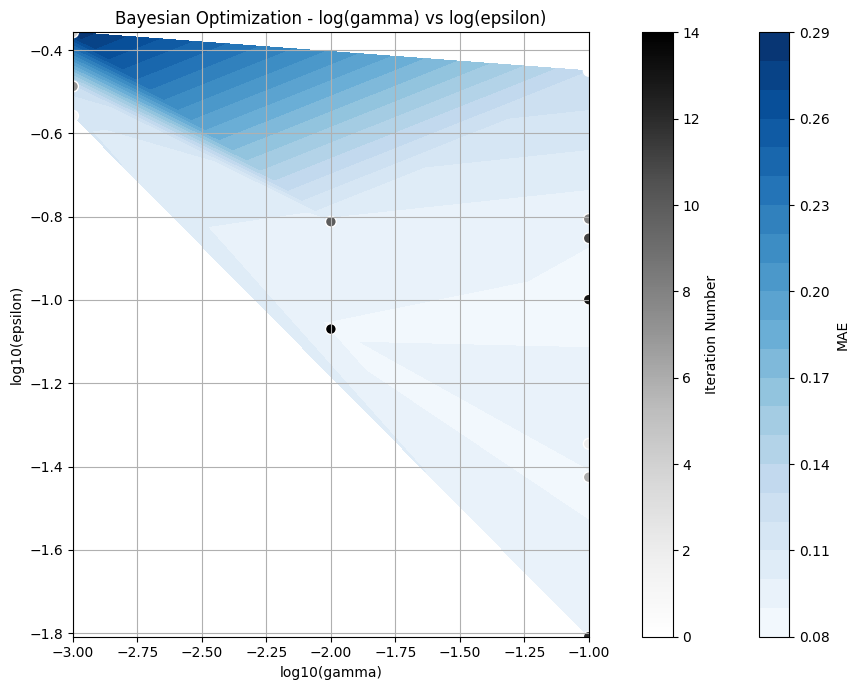

In [ ]:
plot_optuna_log_surface(
    x_vals=gamma_vals,
    y_vals=epsilon_vals,
    z_vals=maes,
    iters=iters,
    xlabel="gamma",
    ylabel="epsilon",
    title="Bayesian Optimization - log(gamma) vs log(epsilon)"
)


Experimento:

Se hará una búsqueda bayesiana con Optuna y un refinamiento con GridSearchCV, todo aplicado a un modelo SVR (Support Vector Regression) con transformación logarítmica de la variable objetivo.

In [ ]:
# === Pipeline base ===
def build_svr_pipeline(params):
    model = SVR(C=params['C'], epsilon=params['epsilon'], gamma=params['gamma'], kernel='rbf')
    return Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])

# === Transformación logarítmica ===
ytrain_log = np.log1p(ytrain)
ytest_log = np.log1p(ytest)

# === Búsqueda bayesiana con Optuna (más profunda) ===
def objective_svr(trial):
    params = {
        'C': trial.suggest_float('C', 1e-1, 200, log=True),
        'epsilon': trial.suggest_float('epsilon', 0.01, 0.4),
        'gamma': trial.suggest_float('gamma', 1e-4, 1.0, log=True)
    }
    pipeline = build_svr_pipeline(params)
    scores = cross_validate(pipeline, Xtrain, ytrain_log, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
    return -np.mean(scores['test_score'])

study = optuna.create_study(direction='minimize')
study.optimize(objective_svr, n_trials=35)  # Mayor exploración

# === Refinamiento GridSearch con top-2 trials ===
df_trials = study.trials_dataframe(attrs=("params", "value")).dropna().sort_values("value").head(2)

grid_C = np.unique(np.concatenate([
    [float(row["params_C"]) * 0.95, float(row["params_C"]) * 1.05]
    for _, row in df_trials.iterrows()
]))
grid_gamma = np.unique(np.concatenate([
    [float(row["params_gamma"]) * 0.95, float(row["params_gamma"]) * 1.05]
    for _, row in df_trials.iterrows()
]))
grid_epsilon = np.unique(np.concatenate([
    [max(0.01, float(row["params_epsilon"]) - 0.015), float(row["params_epsilon"]) + 0.015]
    for _, row in df_trials.iterrows()
]))

fine_grid = {
    'model__C': grid_C,
    'model__gamma': grid_gamma,
    'model__epsilon': grid_epsilon
}

pipeline_base = Pipeline([
    ('preprocessing', preprocessor),
    ('scaler', MinMaxScaler()),
    ('model', SVR(kernel='rbf'))
])

grid_refined = GridSearchCV(
    pipeline_base,
    param_grid=fine_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)
grid_refined.fit(Xtrain, ytrain_log)

# === Mejores hiperparámetros refinados ===
best_params_refined = {k.replace('model__', ''): v for k, v in grid_refined.best_params_.items()}
print("🔧 Hiperparámetros óptimos:", best_params_refined)

# === Evaluación final ===
pipeline_final = build_svr_pipeline(best_params_refined)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

ypred_cv_log = cross_val_predict(pipeline_final, Xtrain, ytrain_log, cv=kf, n_jobs=-1)
ypred_cv = np.expm1(ypred_cv_log)

print("\n📈 Validación cruzada (5 folds)")
print(f"MAE:  {mean_absolute_error(ytrain, ypred_cv):.2f}")
print(f"MSE:  {mean_squared_error(ytrain, ypred_cv):.2f}")
print(f"R2:   {r2_score(ytrain, ypred_cv):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(ytrain, ypred_cv):.4f}")

# === Evaluación en test ===
pipeline_final.fit(Xtrain, ytrain_log)
ypred_test = np.expm1(pipeline_final.predict(Xtest))

print("\n📊 Test set")
print(f"MAE:  {mean_absolute_error(ytest, ypred_test):.2f}")
print(f"MSE:  {mean_squared_error(ytest, ypred_test):.2f}")
print(f"R2:   {r2_score(ytest, ypred_test):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(ytest, ypred_test):.4f}")


[I 2025-05-19 17:59:13,692] A new study created in memory with name: no-name-b1303c76-6b9b-41dd-9528-037b72fa9209
[I 2025-05-19 17:59:15,377] Trial 0 finished with value: 0.10084670664987112 and parameters: {'C': 24.923047330847893, 'epsilon': 0.13753362966902838, 'gamma': 0.00039239812354617033}. Best is trial 0 with value: 0.10084670664987112.
[I 2025-05-19 17:59:17,217] Trial 1 finished with value: 0.1482273040082982 and parameters: {'C': 3.429904498345513, 'epsilon': 0.31419042087437604, 'gamma': 0.0007841840348334154}. Best is trial 0 with value: 0.10084670664987112.
[I 2025-05-19 17:59:18,538] Trial 2 finished with value: 0.21026005597216474 and parameters: {'C': 3.464182959425612, 'epsilon': 0.3095871084665399, 'gamma': 0.0001642011644521589}. Best is trial 0 with value: 0.10084670664987112.
[I 2025-05-19 17:59:19,777] Trial 3 finished with value: 0.10398458909626843 and parameters: {'C': 0.12783003010332092, 'epsilon': 0.09602586491209593, 'gamma': 0.041620358904264854}. Best i

🔧 Hiperparámetros óptimos: {'C': np.float64(28.12808765528), 'epsilon': np.float64(0.03546752070521886), 'gamma': np.float64(0.013875682636494831)}

📈 Validación cruzada (5 folds)
MAE:  15396.68
MSE:  2333919086.68
R2:   0.6165
MAPE: 0.0946

📊 Test set
MAE:  13817.24
MSE:  1140506498.29
R2:   0.8378
MAPE: 0.0795


Los mejores modelos observados en el conjunto de test fueron:

- KernelRidge - Optuna MAE: 14194.2702

- SVR - Optuna MAE:  13865.7656

- SVR - Optuna + GridRefined MAE: 13817.24